In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)


In [2]:
data_path = Path("../responses.csv")

df_raw = pd.read_csv(data_path)
df_raw.head()


,Name,Email,Team,Team lead,AI code assistant usage,Claude Code usage level,Coder Usage,Coding activity level,Level,Tenure band,Which team are you a part of?,Where do you primarily work in the tech stack,How frequently do you currently use AI tools/models in your development process?,Which AI tools do you currently use for professional or personal development? (select all that apply),Where do you primarily use AI in your development workflow? (Select all that apply),"On a scale of 1 to 5, how would you rate the overall helpfulness of AI in your daily development tasks?","Have you ever written an `agents.md`, modified your `.claude` directory, or added context specifically for agents in other way?"
0,Théo DEVANTOY,theo@coder.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Customer Solutions,DevOps/Networking,Daily,"ChatGPT in browser, Claude in browser, Cursor,...","Writing new code, Reviewing PRs/Code, Debuggin...",Very Helpful,Yes -- but I didn't notice much impact
1,Danny Kopping,danny@coder.com,Kiwi,michael.suchacz@coder.com,Daily,Light,Daily,Writes code regularly,IC6,NaN,Kiwi,Backend,Daily,"ChatGPT in browser, Claude in browser, Claude ...","Writing new code, Reviewing PRs/Code, Writing ...",Very Helpful,No -- I know it's possible but haven't taken t...
2,Allen Shvarts,allen.shvarts@coder.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,Other,Daily,"ChatGPT in browser, Claude in browser, Claude ...","Architecture or design assistance, Other",Extremely Helpful,No -- I know it's possible but haven't taken t...
3,Jake Howell,jacob@coder.com,Kiwi,michael.suchacz@coder.com,NaN,Light,NaN,NaN,IC4,NaN,Kiwi,Frontend,Daily,"ChatGPT in browser, Cursor, Claude Code","Writing new code, Reviewing PRs/Code, Debuggin...",Very Helpful,No -- I know it's possible but haven't taken t...
4,Asher,asher@coder.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mango,Backend,Several times a week,"ChatGPT in browser, Claude in browser, Blink","Debugging, Other",Slightly Helpful,Yes -- and it made a meaningful difference


In [3]:
# Basic column cleanup
team_col = df_raw['Team'].fillna(df_raw['Which team are you a part of?'])
workflow_col = df_raw['Where do you primarily use AI in your development workflow? (Select all that apply)']

# Helper to split multi-select responses
def split_multiselect(series):
    return (
        series.fillna('')
        .str.split(',')
        .apply(lambda items: [item.strip() for item in items if item and item.strip()])
    )

workflow_long = (
    df_raw.assign(team=team_col, workflow_areas=split_multiselect(workflow_col))
    .explode('workflow_areas')
    .dropna(subset=['workflow_areas', 'team'])
)

workflow_counts = (
    workflow_long.groupby(['team', 'workflow_areas'])
    .size()
    .reset_index(name='respondent_count')
)

workflow_counts.head()


,team,workflow_areas,respondent_count
0,Banana,Debugging,1
1,Banana,Documentation,1
2,Banana,Reviewing PRs/Code,1
3,Banana,Writing new code,2
4,Banana,Writing tests and/or test case generation,2


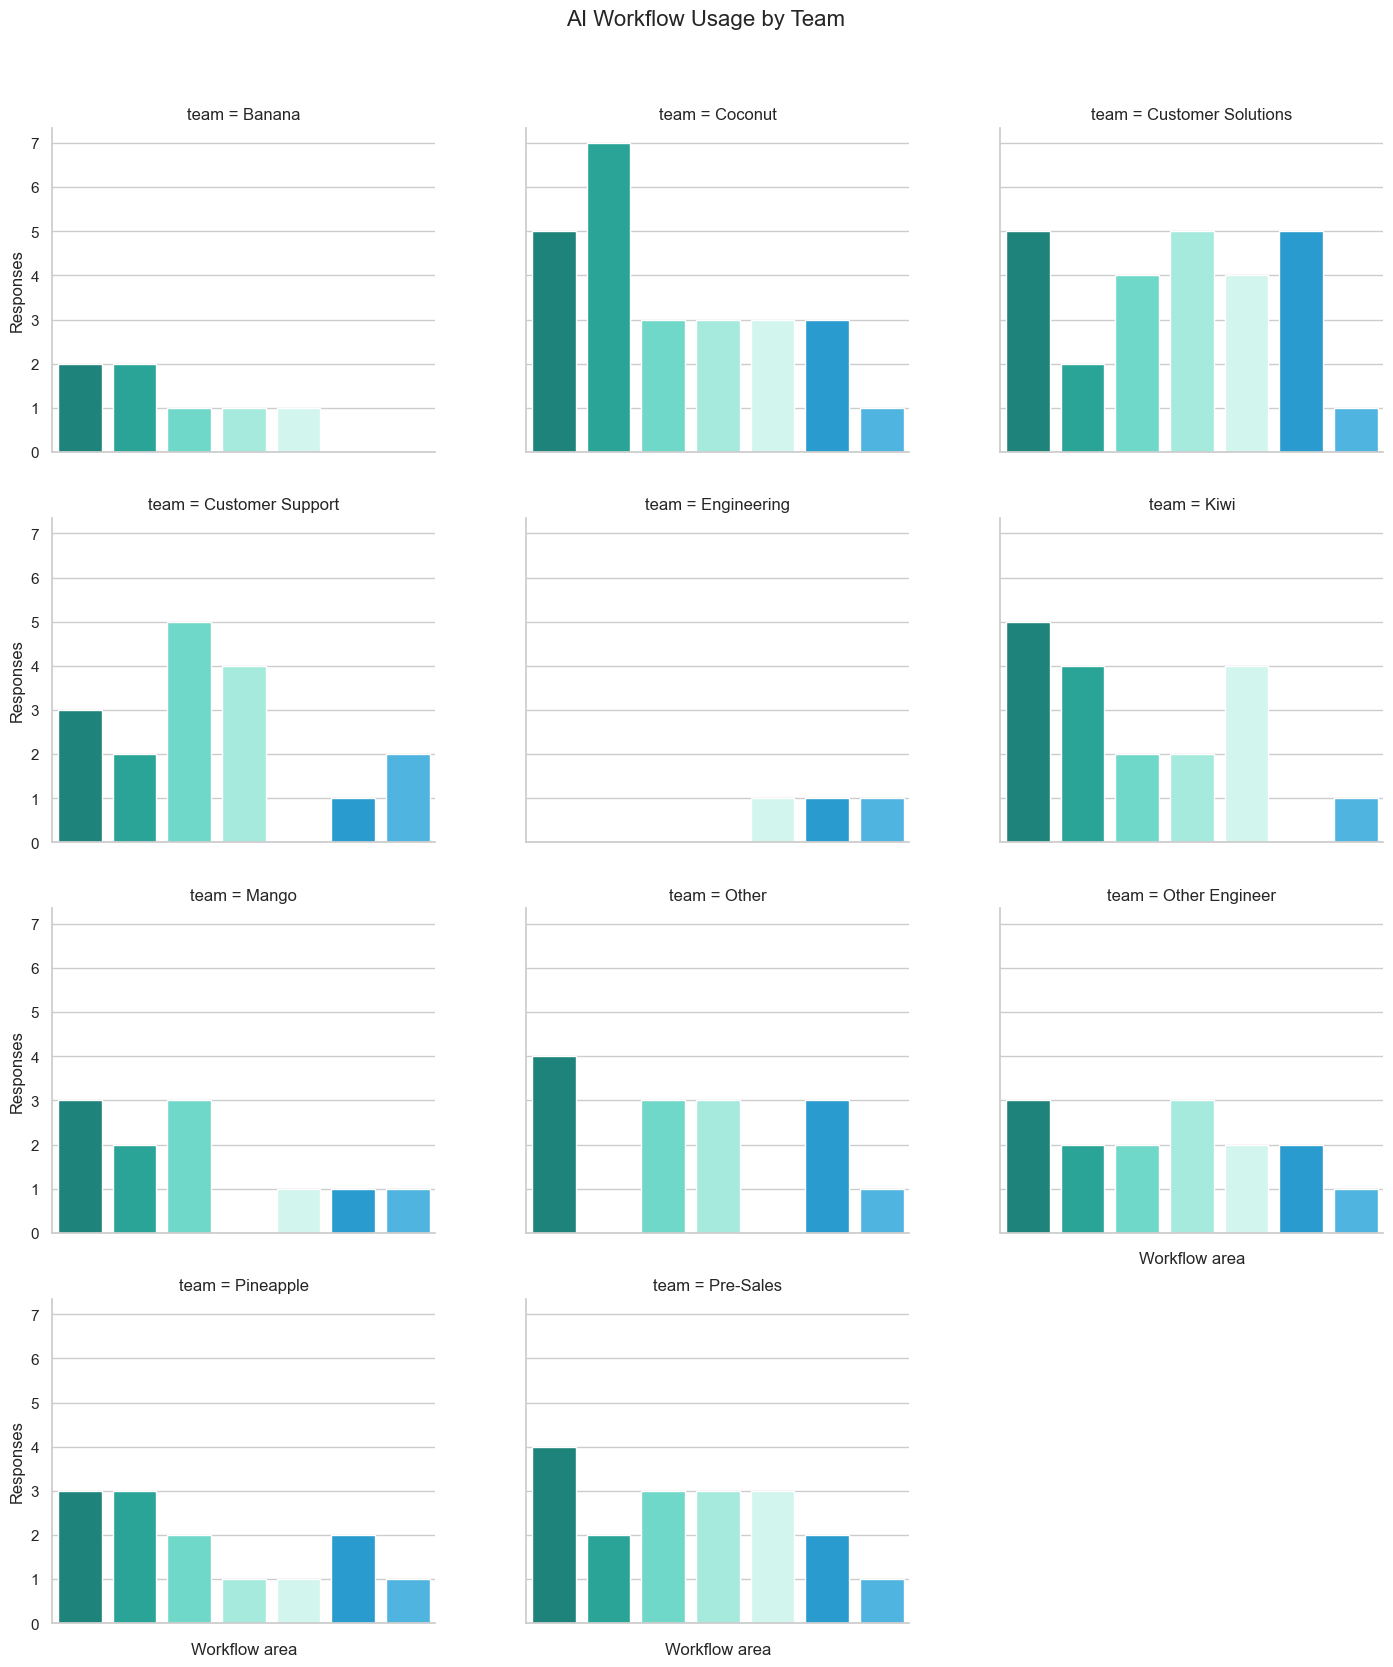

In [4]:
# Plot: AI workflow usage by team
# Modern teal/blue/green gradient palette
teal_palette = sns.color_palette(["#0D9488", "#14B8A6", "#5EEAD4", "#99F6E4", "#CCFBF1", "#0EA5E9", "#38BDF8", "#7DD3FC"])
palette = teal_palette[:workflow_counts['workflow_areas'].nunique()]

plot_data = workflow_counts.sort_values(['team', 'respondent_count'], ascending=[True, False])

g = sns.catplot(
    data=plot_data,
    kind='bar',
    x='workflow_areas',
    y='respondent_count',
    col='team',
    col_wrap=3,
    height=4,
    aspect=1.2,
    palette=palette,
    hue='workflow_areas',
    legend=False
)

g.set_xticklabels(rotation=30, ha='right')
g.set_axis_labels("Workflow area", "Responses")
g.fig.suptitle("AI Workflow Usage by Team", fontsize=16, y=1.05)
plt.show()


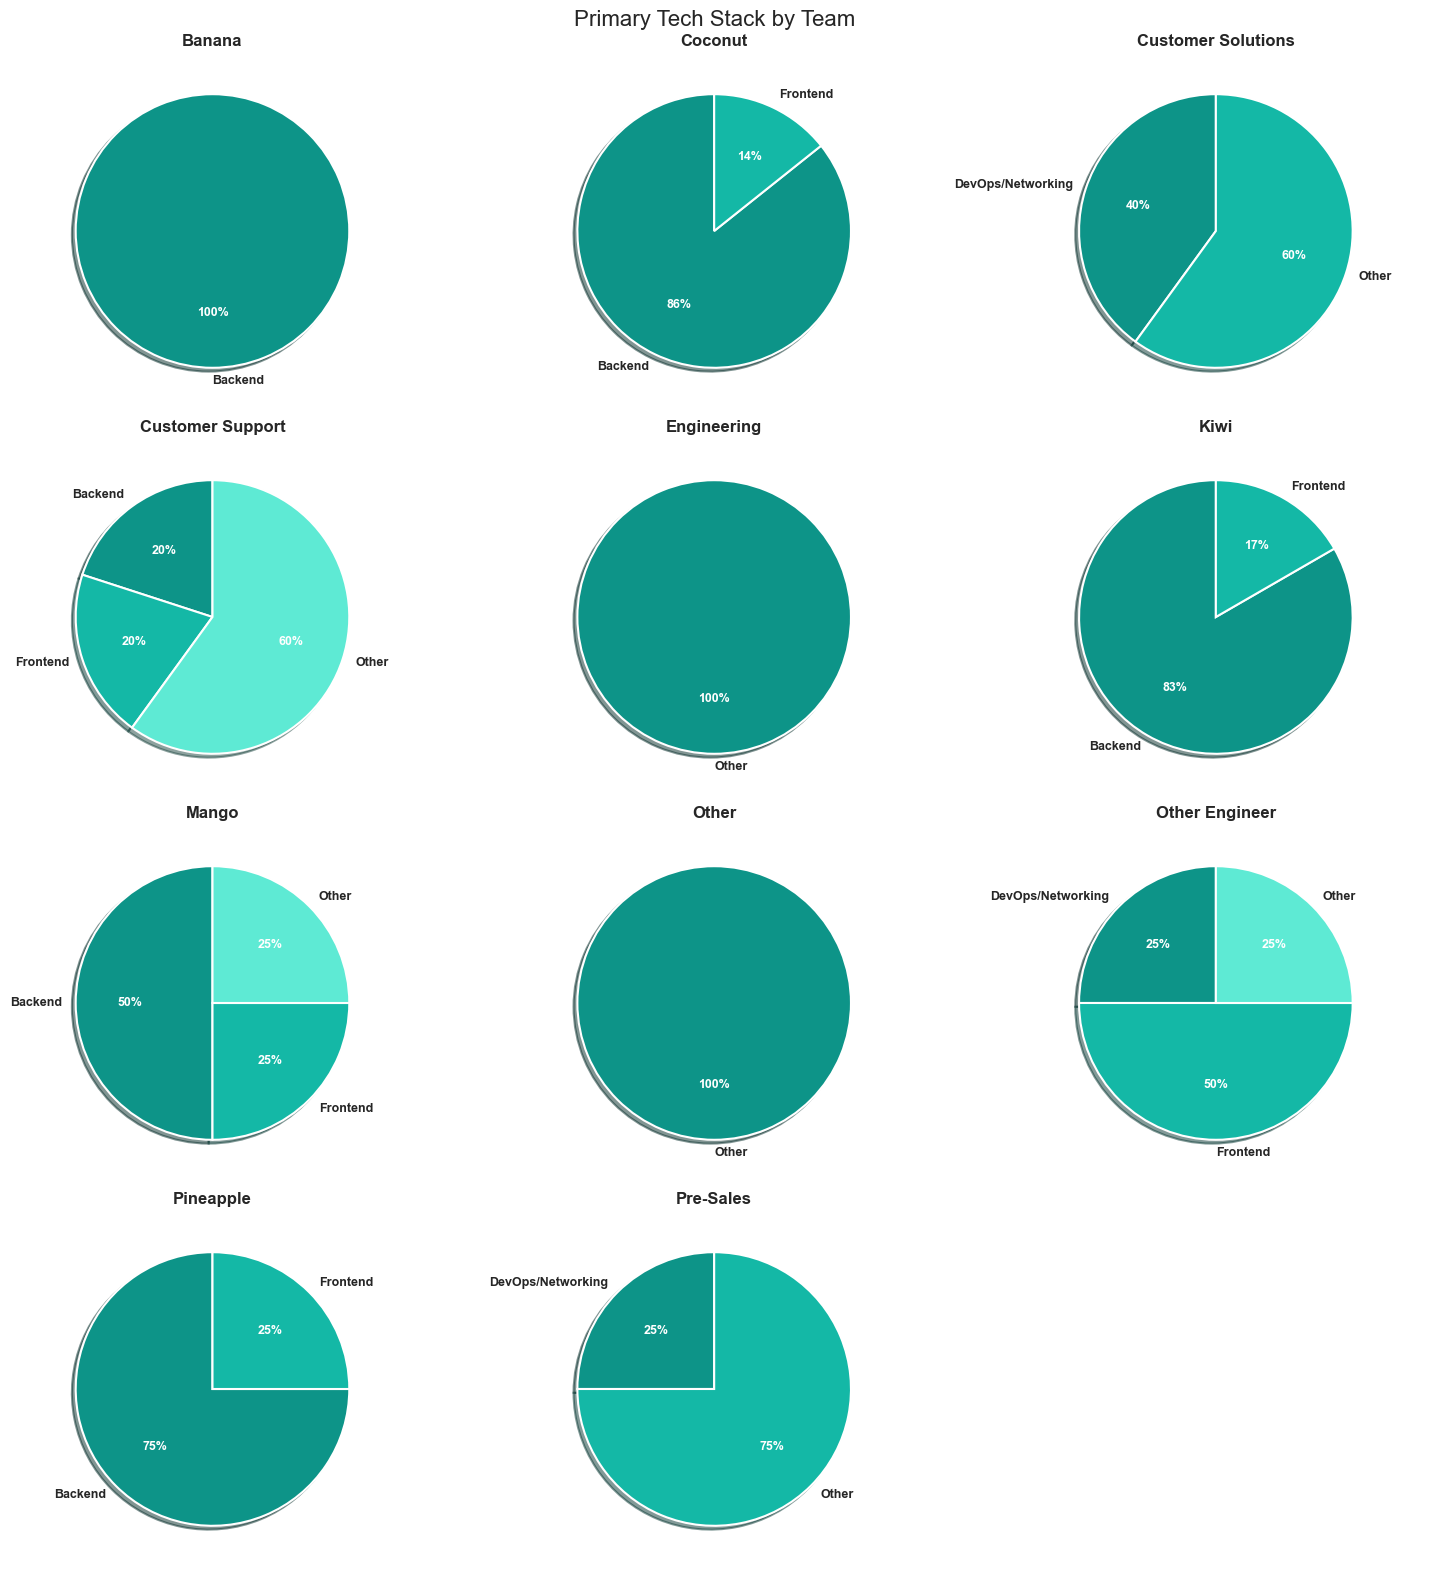

In [5]:
# Pie charts: tech stack distribution by team
tech_stack_col = df_raw['Where do you primarily work in the tech stack'].fillna('Not specified')

tech_counts = (
    df_raw.assign(team=team_col, tech_stack=tech_stack_col)
    .dropna(subset=['team'])
    .groupby(['team', 'tech_stack'])
    .size()
    .reset_index(name='respondent_count')
)

teams = tech_counts['team'].unique()
cols = 3
rows = int(np.ceil(len(teams) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Modern teal gradient colors for pie charts
pie_colors = ['#0D9488', '#14B8A6', '#5EEAD4', '#99F6E4', '#CCFBF1', '#0EA5E9', '#38BDF8', '#7DD3FC']

for ax, team in zip(axes, teams):
    team_data = tech_counts[tech_counts['team'] == team]
    colors = pie_colors[:len(team_data)]
    wedges, texts, autotexts = ax.pie(
        team_data['respondent_count'],
        labels=team_data['tech_stack'],
        autopct='%1.0f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 9, 'weight': 'bold'},
        shadow=True,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
    ax.set_title(f"{team}", fontsize=12, weight='bold', pad=10)

# Hide any unused subplots
for ax in axes[len(teams):]:
    ax.axis('off')

fig.suptitle("Primary Tech Stack by Team", fontsize=16)
plt.tight_layout()
plt.show()


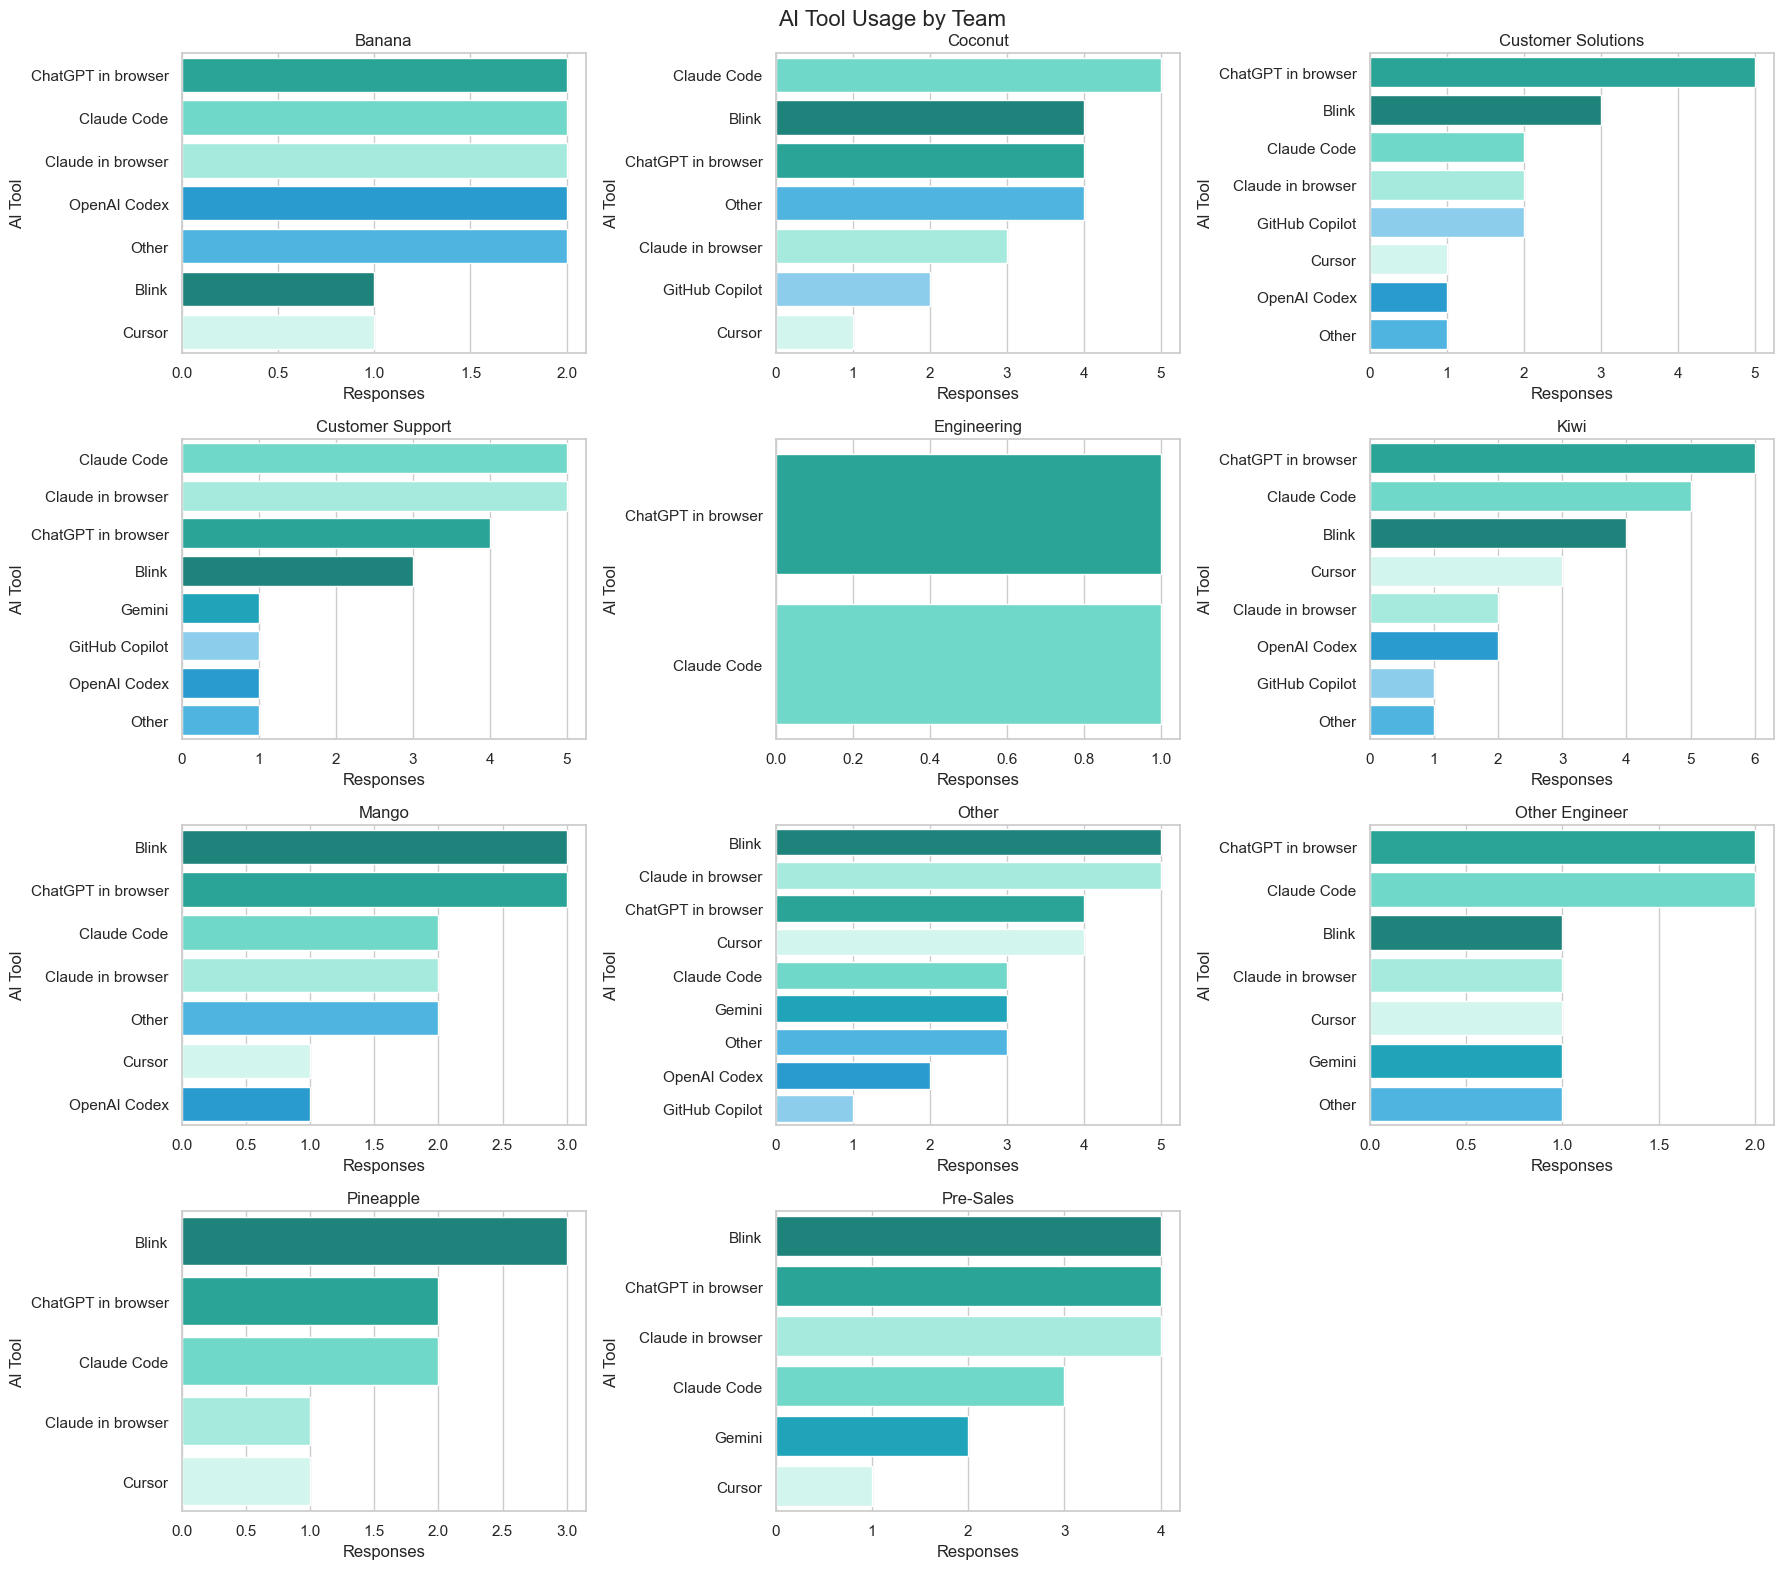

In [6]:
# Bar charts: AI tool usage by team
ai_tools_col = df_raw['Which AI tools do you currently use for professional or personal development? (select all that apply)']

ai_tool_long = (
    df_raw.assign(team=team_col, ai_tools=split_multiselect(ai_tools_col))
    .explode('ai_tools')
    .dropna(subset=['ai_tools', 'team'])
)

ai_tool_counts = (
    ai_tool_long.groupby(['team', 'ai_tools'])
    .size()
    .reset_index(name='respondent_count')
)

# Modern teal/blue/green gradient for tools
tool_palette_list = ['#0D9488', '#14B8A6', '#5EEAD4', '#99F6E4', '#CCFBF1', '#0EA5E9', '#38BDF8', '#7DD3FC', 
                     '#06B6D4', '#22D3EE', '#67E8F9', '#A5F3FC', '#0891B2', '#155E75', '#164E63']
palette_tools = dict(
    zip(
        ai_tool_counts['ai_tools'].unique(),
        tool_palette_list[:ai_tool_counts['ai_tools'].nunique()]
    )
)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for ax, team in zip(axes, teams):
    team_data = ai_tool_counts[ai_tool_counts['team'] == team].sort_values('respondent_count', ascending=False)
    sns.barplot(
        data=team_data,
        x='respondent_count',
        y='ai_tools',
        hue='ai_tools',
        palette=palette_tools,
        dodge=False,
        legend=False,
        ax=ax
    )
    ax.set_title(team)
    ax.set_xlabel('Responses')
    ax.set_ylabel('AI Tool')

for ax in axes[len(teams):]:
    ax.axis('off')

fig.suptitle('AI Tool Usage by Team', fontsize=16)
plt.tight_layout()
plt.show()


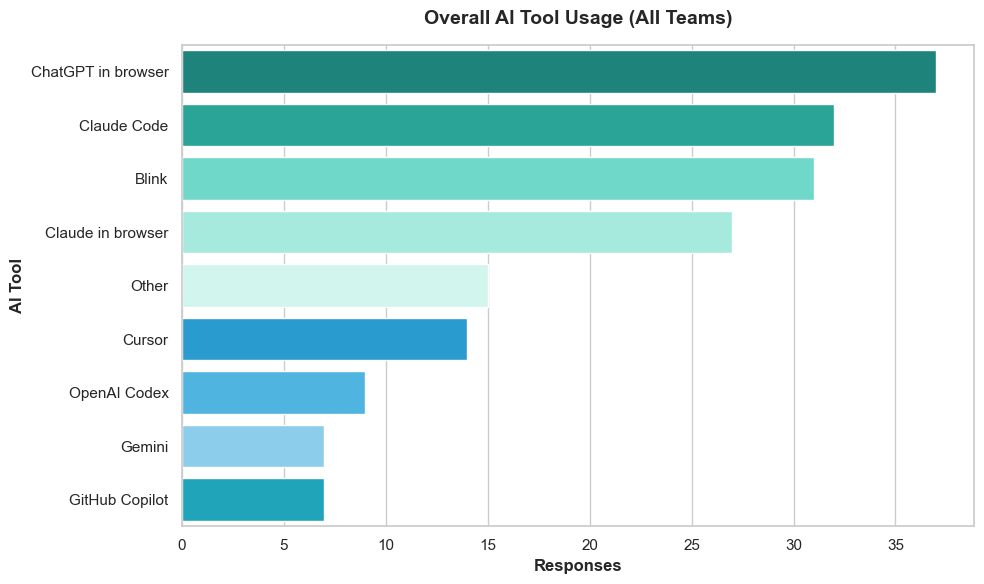

In [7]:
# Overall AI tool usage across all teams
overall_tool_counts = (
    ai_tool_long.groupby('ai_tools')
    .size()
    .reset_index(name='respondent_count')
    .sort_values('respondent_count', ascending=False)
)

plt.figure(figsize=(10, 6))
# Use teal gradient for overall tools
tool_colors = ['#0D9488', '#14B8A6', '#5EEAD4', '#99F6E4', '#CCFBF1', '#0EA5E9', '#38BDF8', '#7DD3FC', 
               '#06B6D4', '#22D3EE', '#67E8F9', '#A5F3FC']
sns.barplot(
    data=overall_tool_counts,
    x='respondent_count',
    y='ai_tools',
    palette=tool_colors[:len(overall_tool_counts)],
    hue='ai_tools',
    legend=False
)
plt.title('Overall AI Tool Usage (All Teams)', fontsize=14, weight='bold', pad=15)
plt.xlabel('Responses', fontsize=12, weight='bold')
plt.ylabel('AI Tool', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


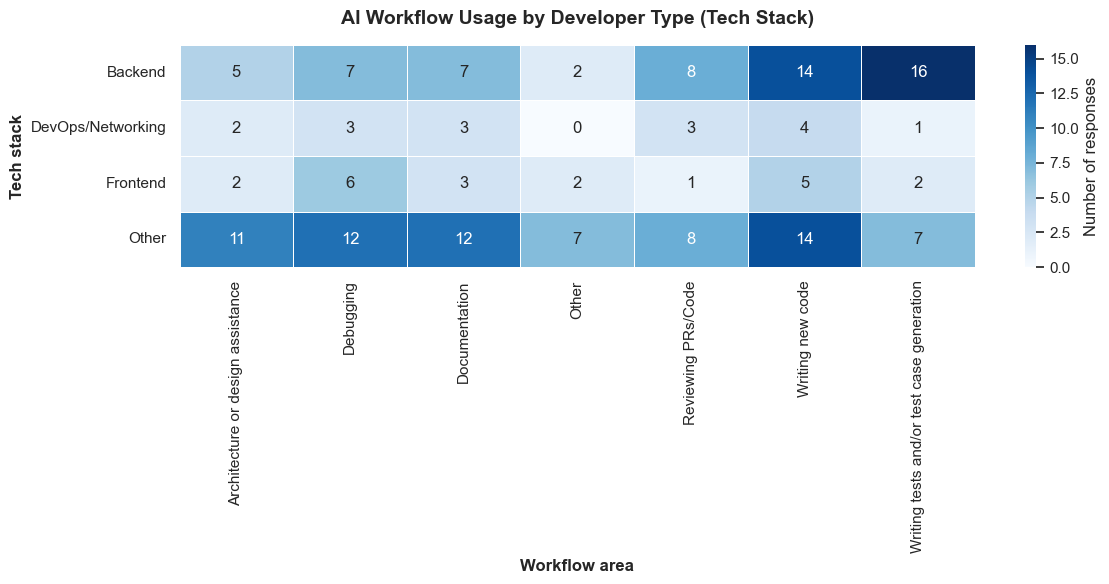

In [8]:
# Heatmap: AI workflow usage by developer type (tech stack)
tech_workflow_long = (
    df_raw.assign(
        tech_stack=tech_stack_col.str.strip(),
        workflow_areas=split_multiselect(workflow_col)
    )
    .explode('workflow_areas')
    .dropna(subset=['workflow_areas', 'tech_stack'])
)

tech_workflow_counts = (
    tech_workflow_long.groupby(['tech_stack', 'workflow_areas'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    tech_workflow_counts,
    annot=True,
    fmt='d',
    cmap='Blues',  # Use Blues instead of YlGnBu for consistency
    cbar_kws={'label': 'Number of responses'},
    linewidths=0.5,
    linecolor='white'
)
ax.set_yticklabels(
    [label.get_text().replace(' / ', '\n') for label in ax.get_yticklabels()],
    rotation=0
)
plt.title('AI Workflow Usage by Developer Type (Tech Stack)', fontsize=14, weight='bold', pad=15)
plt.xlabel('Workflow area', fontsize=12, weight='bold')
plt.ylabel('Tech stack', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


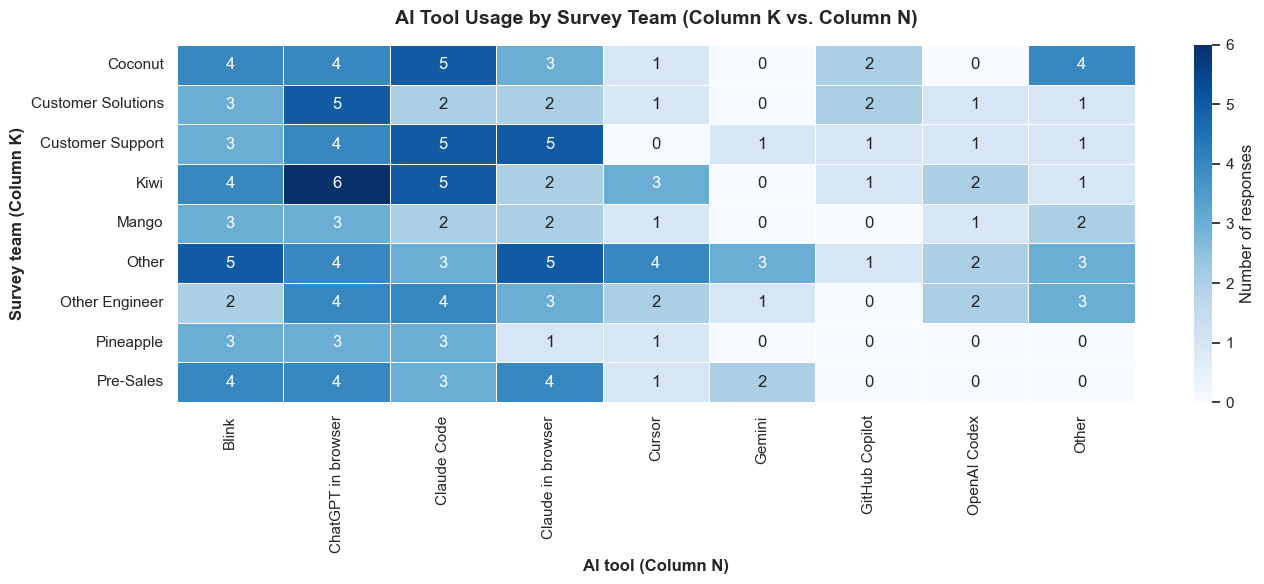

In [9]:
# Heatmap: AI tool usage by survey team (column K)
survey_team_col = df_raw['Which team are you a part of?'].fillna('Not specified')

team_tool_long = (
    df_raw.assign(survey_team=survey_team_col, ai_tools=split_multiselect(ai_tools_col))
    .explode('ai_tools')
    .dropna(subset=['ai_tools', 'survey_team'])
)

team_tool_counts = (
    team_tool_long.groupby(['survey_team', 'ai_tools'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    team_tool_counts,
    annot=True,
    fmt='d',
    cmap='Blues',  # Use Blues for consistency
    cbar_kws={'label': 'Number of responses'},
    linewidths=0.5,
    linecolor='white'
)
ax.set_title('AI Tool Usage by Survey Team (Column K vs. Column N)', fontsize=14, weight='bold', pad=15)
ax.set_xlabel('AI tool (Column N)', fontsize=12, weight='bold')
ax.set_ylabel('Survey team (Column K)', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


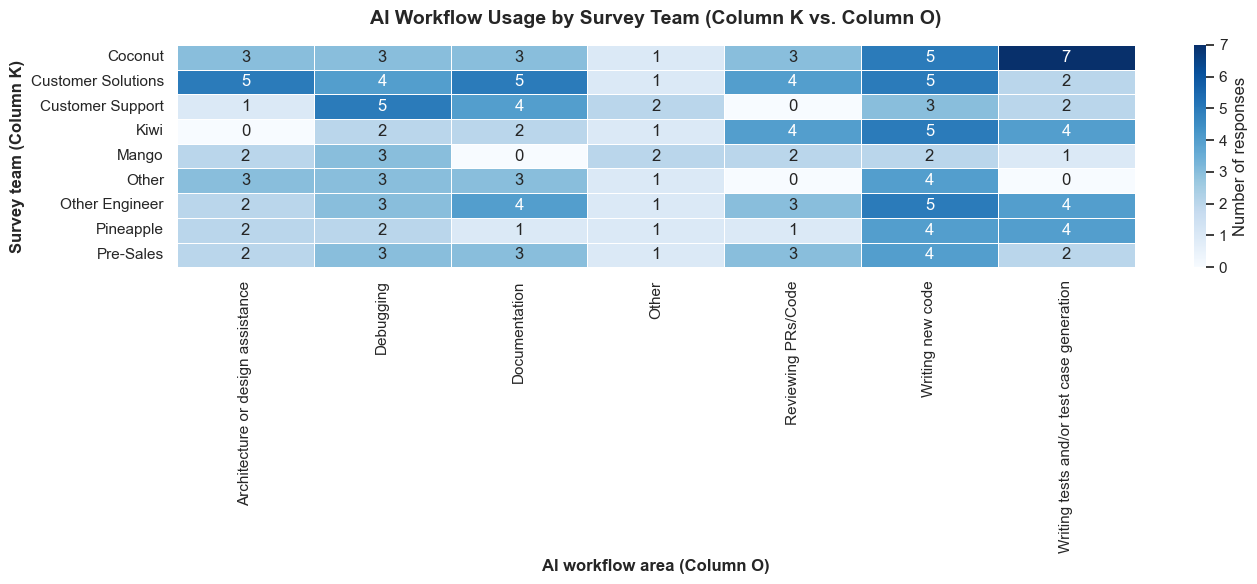

In [10]:
# Heatmap: Survey team (column K) vs. primary AI usage areas (column O)
survey_team_workflow_long = (
    df_raw.assign(
        survey_team=survey_team_col,
        workflow_areas=split_multiselect(workflow_col)
    )
    .explode('workflow_areas')
    .dropna(subset=['survey_team', 'workflow_areas'])
)

survey_team_workflow_counts = (
    survey_team_workflow_long.groupby(['survey_team', 'workflow_areas'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    survey_team_workflow_counts,
    annot=True,
    fmt='d',
    cmap='Blues',  # Use Blues for consistency
    cbar_kws={'label': 'Number of responses'},
    linewidths=0.5,
    linecolor='white'
)
ax.set_title('AI Workflow Usage by Survey Team (Column K vs. Column O)', fontsize=14, weight='bold', pad=15)
ax.set_xlabel('AI workflow area (Column O)', fontsize=12, weight='bold')
ax.set_ylabel('Survey team (Column K)', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


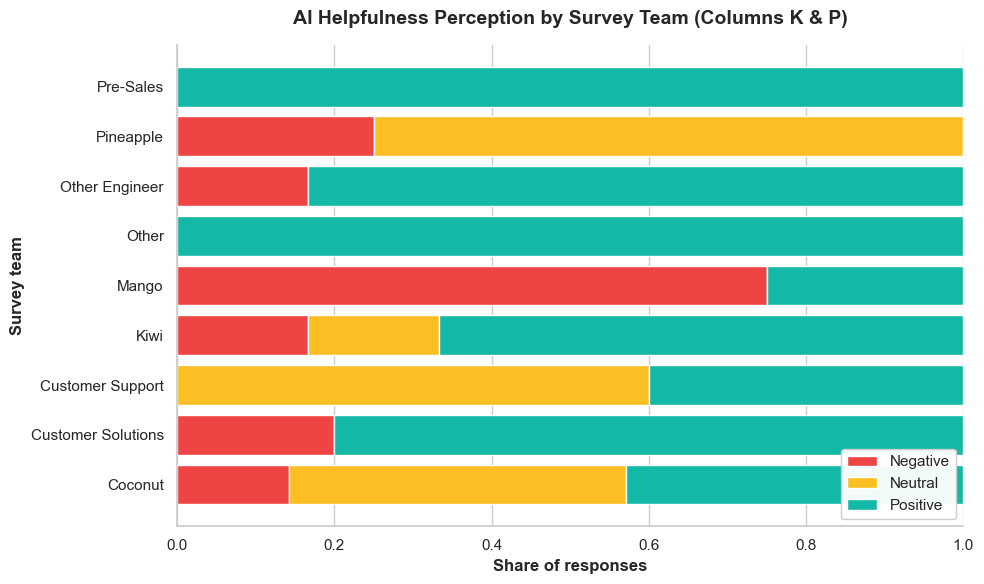

In [11]:
# Diverging bar chart: AI helpfulness ratings by survey team (columns K & P)
helpfulness_col_name = next(
    col for col in df_raw.columns
    if 'how would you rate the overall helpfulness of AI' in col
)

helpfulness_order = [
    'Not at all Helpful',
    'Slightly Helpful',
    'Moderately Helpful',
    'Very Helpful',
    'Extremely Helpful'
]

helpfulness_counts = (
    df_raw.assign(survey_team=survey_team_col, helpfulness=df_raw[helpfulness_col_name])
    .dropna(subset=['survey_team', 'helpfulness'])
    .groupby(['survey_team', 'helpfulness'])
    .size()
    .reset_index(name='respondent_count')
)

helpfulness_pivot = helpfulness_counts.pivot(
    index='survey_team',
    columns='helpfulness',
    values='respondent_count'
).fillna(0)

helpfulness_pivot = helpfulness_pivot.reindex(columns=helpfulness_order, fill_value=0)
helpfulness_pct = helpfulness_pivot.div(helpfulness_pivot.sum(axis=1), axis=0)

positive = helpfulness_pct[['Very Helpful', 'Extremely Helpful']].sum(axis=1)
neutral = helpfulness_pct[['Moderately Helpful']].sum(axis=1)
negative = helpfulness_pct[['Not at all Helpful', 'Slightly Helpful']].sum(axis=1)

helpfulness_summary = pd.DataFrame({
    'positive': positive,
    'neutral': neutral,
    'negative': negative
}).fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))

# Use modern gradient colors: red/orange (negative), yellow (neutral), teal/green (positive)
ax.barh(helpfulness_summary.index, helpfulness_summary['negative'], color='#EF4444', label='Negative', edgecolor='white', linewidth=1)
ax.barh(helpfulness_summary.index, helpfulness_summary['neutral'], left=helpfulness_summary['negative'], color='#FBBF24', label='Neutral', edgecolor='white', linewidth=1)
ax.barh(helpfulness_summary.index, helpfulness_summary['positive'], left=helpfulness_summary['negative'] + helpfulness_summary['neutral'], color='#14B8A6', label='Positive', edgecolor='white', linewidth=1)

ax.set_title('AI Helpfulness Perception by Survey Team (Columns K & P)', fontsize=14, weight='bold', pad=15)
ax.set_xlabel('Share of responses', fontsize=12, weight='bold')
ax.set_ylabel('Survey team', fontsize=12, weight='bold')
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


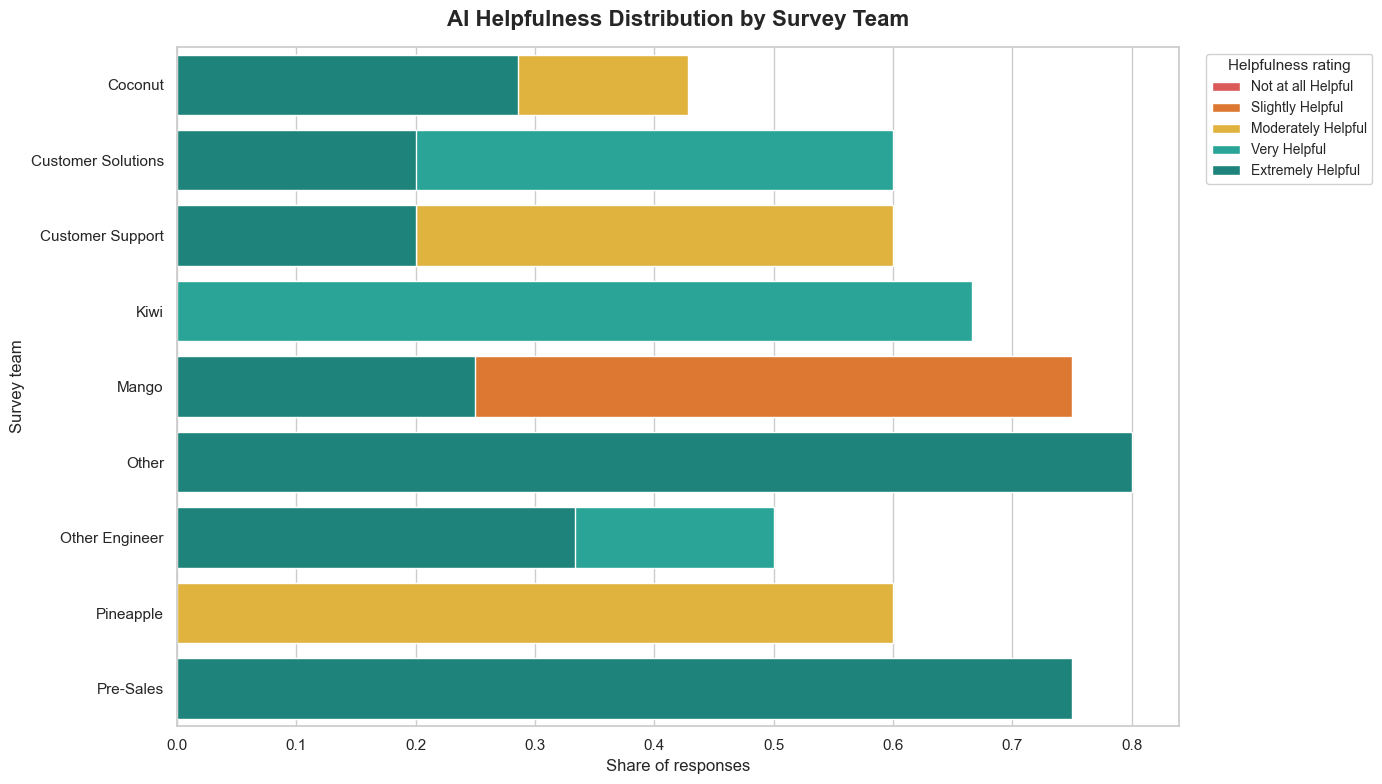

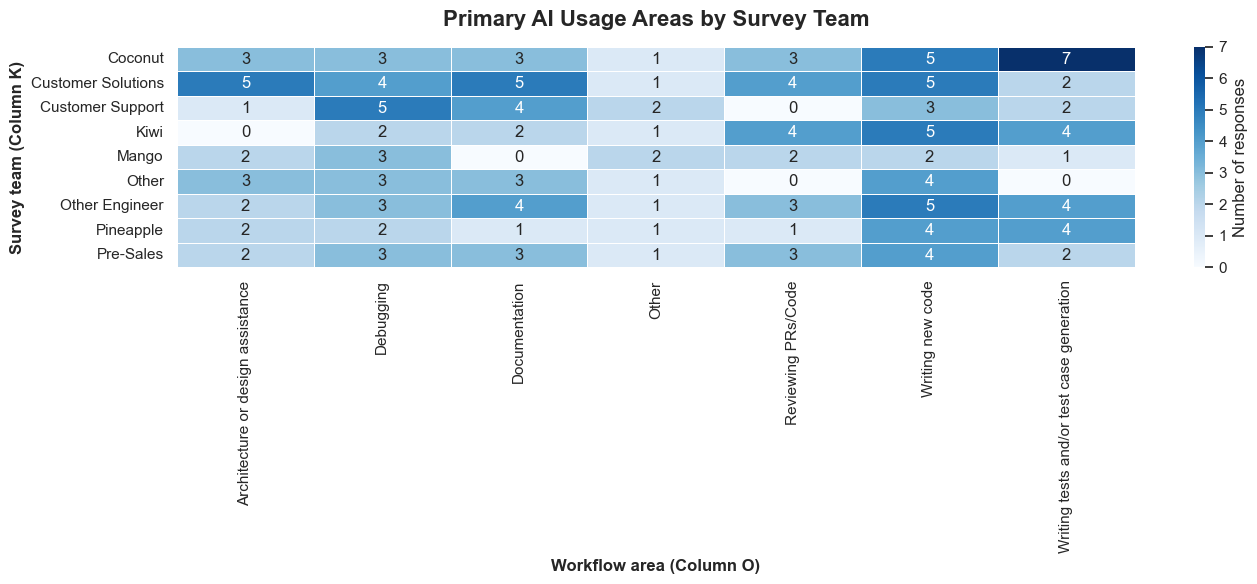

In [12]:
# Combined view: AI helpfulness vs. primary usage by survey team (columns K, P, O)

# Prepare helpfulness data with percentages
helpfulness_counts_full = (
    df_raw.assign(survey_team=survey_team_col, helpfulness=df_raw[helpfulness_col_name])
    .dropna(subset=['survey_team', 'helpfulness'])
    .groupby(['survey_team', 'helpfulness'])
    .size()
    .reset_index(name='count')
)

# Calculate percentages per team (fixing deprecation warning)
helpfulness_pct_full = (
    helpfulness_counts_full
    .merge(
        helpfulness_counts_full.groupby('survey_team')['count'].sum().reset_index(name='total'),
        on='survey_team'
    )
    .assign(share=lambda df: df['count'] / df['total'])
    .drop(columns=['total'])
)

# Modern color palette: gradient from negative (red) to positive (teal/green)
helpfulness_palette = ['#EF4444', '#F97316', '#FBBF24', '#14B8A6', '#0D9488']

# Chart 1: AI Helpfulness Distribution by Survey Team
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=helpfulness_pct_full,
    x='share',
    y='survey_team',
    hue='helpfulness',
    order=sorted(helpfulness_pct_full['survey_team'].unique()),
    hue_order=helpfulness_order,
    palette=helpfulness_palette,
    dodge=False
)
ax.set_title('AI Helpfulness Distribution by Survey Team', fontsize=16, weight='bold', pad=15)
ax.set_xlabel('Share of responses', fontsize=12)
ax.set_ylabel('Survey team', fontsize=12)
ax.legend(
    title='Helpfulness rating',
    title_fontsize=11,
    fontsize=10,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    framealpha=0.9
)
plt.tight_layout()
plt.show()

# Chart 2: Primary AI Usage Areas by Survey Team
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    survey_team_workflow_counts,
    annot=True,
    fmt='d',
    cmap='Blues',  # Use Blues for consistency with other charts
    cbar_kws={'label': 'Number of responses'},
    linewidths=0.5,
    linecolor='white'
)
ax.set_title('Primary AI Usage Areas by Survey Team', fontsize=16, weight='bold', pad=15)
ax.set_xlabel('Workflow area (Column O)', fontsize=12, weight='bold')
ax.set_ylabel('Survey team (Column K)', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


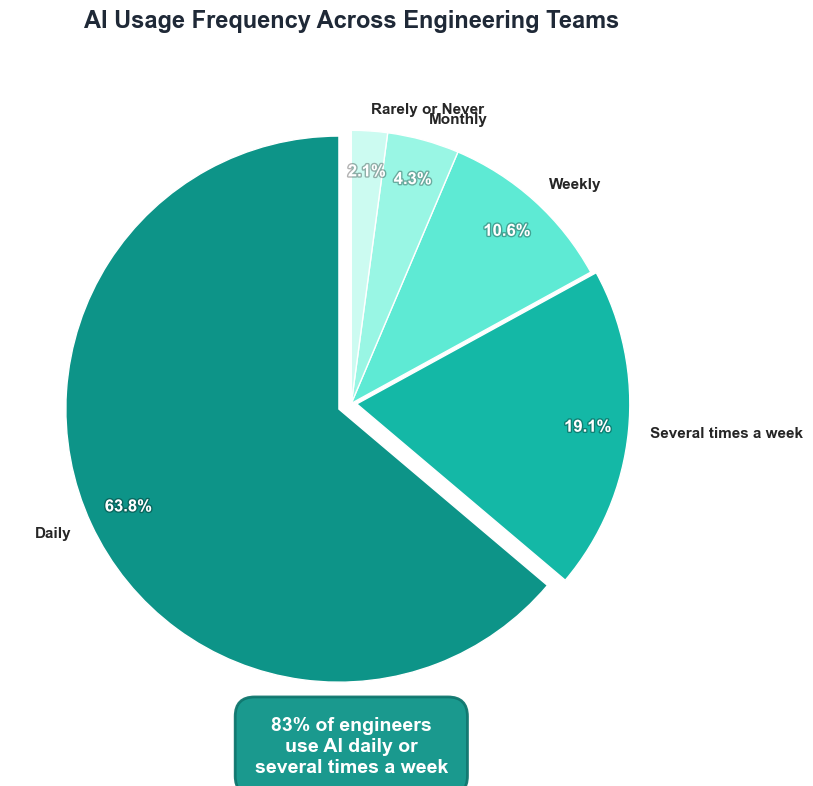


📊 Frequency Distribution:
--------------------------------------------------
  Daily                    : 30 ( 63.8%) ███████████████████████████████
  Several times a week     :  9 ( 19.1%) █████████
  Weekly                   :  5 ( 10.6%) █████
  Monthly                  :  2 (  4.3%) ██
  Rarely or Never          :  1 (  2.1%) █
--------------------------------------------------

✨ Key Insight: 39 out of 47 respondents (83.0%) use AI regularly


In [13]:

# Pie chart: AI usage frequency across all teams
from matplotlib import patheffects

frequency_col = 'How frequently do you currently use AI tools/models in your development process?'

# Define frequency order and count distribution
frequency_order = ['Daily', 'Several times a week', 'Weekly', 'Monthly', 'Rarely or Never']
frequency_counts = (
    df_raw[frequency_col]
    .value_counts()
    .reindex(frequency_order, fill_value=0)
)

# Calculate key statistics
total_responses = len(df_raw.dropna(subset=[frequency_col]))
regular_users = frequency_counts['Daily'] + frequency_counts['Several times a week']
regular_percentage = (regular_users / total_responses) * 100

# Create pie chart with modern, vibrant colors
fig, ax = plt.subplots(figsize=(10, 8))

# Vibrant gradient: deep teal to emerald green (most frequent) to soft pastels (least frequent)
colors = ['#0D9488', '#14B8A6', '#5EEAD4', '#99F6E4', '#CCFBF1']

wedges, texts, autotexts = ax.pie(
    frequency_counts.values,
    labels=frequency_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 11, 'weight': 'bold'},
    pctdistance=0.85,
    labeldistance=1.08,
    explode=(0.05, 0.02, 0, 0, 0)  # Slight explode for most frequent segments
)

# Enhance text readability with shadow effect
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')
    autotext.set_path_effects([
        patheffects.withStroke(linewidth=2, foreground='black', alpha=0.3)
    ])

for text in texts:
    text.set_fontsize(11)
    text.set_weight('bold')

# Add title with better styling
ax.set_title(
    'AI Usage Frequency Across Engineering Teams',
    fontsize=17,
    weight='bold',
    pad=25,
    color='#1F2937'
)

# Add key statistic annotation with modern styling
stat_text = f'{regular_percentage:.0f}% of engineers\nuse AI daily or\nseveral times a week'
ax.text(
    0, -1.35,
    stat_text,
    ha='center',
    fontsize=14,
    weight='bold',
    bbox=dict(
        boxstyle='round,pad=1.0',
        facecolor='#0D9488',
        edgecolor='#0F766E',
        alpha=0.95,
        linewidth=2
    ),
    color='white'
)

plt.tight_layout()
plt.show()

# Print formatted summary statistics
print("\n📊 Frequency Distribution:")
print("-" * 50)
for freq, count in frequency_counts.items():
    pct = (count / total_responses) * 100
    bar = "█" * int(pct / 2)
    print(f"  {freq:25s}: {count:2d} ({pct:5.1f}%) {bar}")
print("-" * 50)
print(f"\n✨ Key Insight: {regular_users} out of {total_responses} respondents ({regular_percentage:.1f}%) use AI regularly")

In [14]:

# Get the helpfulness column
helpfulness_col = 'On a scale of 1 to 5, how would you rate the overall helpfulness of AI in your daily development tasks?'

# Count the ratings
helpfulness_counts = df[helpfulness_col].value_counts()

# Define the order (from best to worst) and map to numeric values
rating_order = ['Extremely Helpful', 'Very Helpful', 'Moderately Helpful', 'Slightly Helpful', 'Not Helpful']
rating_values = {'Extremely Helpful': 5, 'Very Helpful': 4, 'Moderately Helpful': 3, 'Slightly Helpful': 2, 'Not Helpful': 1}

# Reindex to get consistent ordering
helpfulness_counts = helpfulness_counts.reindex(rating_order, fill_value=0)

# Calculate average rating
df['rating_numeric'] = df[helpfulness_col].map(rating_values)
avg_rating = df['rating_numeric'].mean()

# Calculate percentage of 4-5 star ratings
high_ratings = helpfulness_counts['Extremely Helpful'] + helpfulness_counts['Very Helpful']
high_rating_percentage = (high_ratings / len(df)) * 100

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors - gradient from dark green (best) to light/gray (worst)
colors = ['#1B5E20', '#2E7D32', '#FFA726', '#FF7043', '#D32F2F']

# Create horizontal bar chart
bars = ax.barh(rating_order, helpfulness_counts.values, color=colors, height=0.6)

# Add value labels on the bars
for i, (bar, count) in enumerate(zip(bars, helpfulness_counts.values)):
    percentage = (count / len(df)) * 100
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{count} ({percentage:.1f}%)', 
            va='center', fontsize=12, weight='bold')

# Customize the plot
ax.set_xlabel('Number of Responses', fontsize=14, weight='bold')
ax.set_title('AI Helpfulness Ratings: Developers See Real Value', 
             fontsize=18, weight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, max(helpfulness_counts.values) + 5)

# Add grid for readability
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add the key stats as text annotation
stats_text = f'Average Rating: {avg_rating:.2f}/5.0 ⭐\n{high_rating_percentage:.0f}% rate AI as "Very" or "Extremely" Helpful'
plt.text(0.98, 0.02, stats_text, 
         transform=ax.transAxes,
         ha='right', 
         va='bottom',
         fontsize=14, 
         weight='bold',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='#2E7D32', edgecolor='#1B5E20', alpha=0.9),
         color='white')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n⭐ Helpfulness Rating Distribution:")
print(helpfulness_counts)
print(f"\n📊 Average Rating: {avg_rating:.2f} out of 5.0")
print(f"✨ {high_ratings} out of {len(df)} respondents ({high_rating_percentage:.1f}%) rate AI as 'Very' or 'Extremely' Helpful")
print(f"🎯 {helpfulness_counts['Extremely Helpful']} respondents ({(helpfulness_counts['Extremely Helpful']/len(df)*100):.1f}%) rate AI as 'Extremely Helpful'")

NameError: name 'df' is not defined

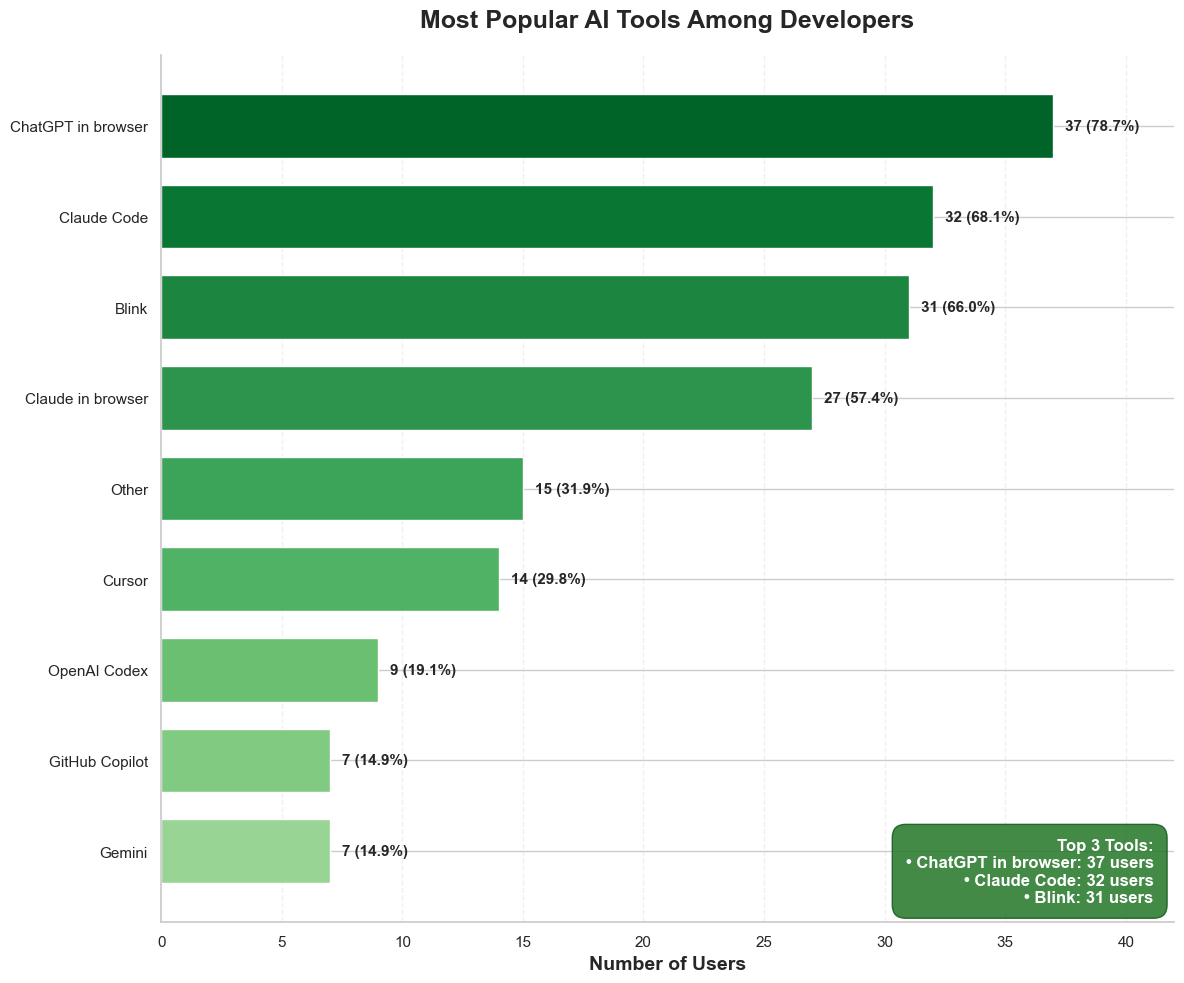


🛠️  Tool Usage Summary:
              Tool  Count  Percentage
ChatGPT in browser     37   78.723404
       Claude Code     32   68.085106
             Blink     31   65.957447
 Claude in browser     27   57.446809
             Other     15   31.914894
            Cursor     14   29.787234
      OpenAI Codex      9   19.148936
            Gemini      7   14.893617
    GitHub Copilot      7   14.893617

📊 Total survey respondents: 47
💡 Note: Respondents could select multiple tools


In [ ]:


# Get the tools column
tools_col = 'Which AI tools do you currently use for professional or personal development? (select all that apply)'

# Parse the multi-select responses (comma-separated values)
all_tools = []
for response in df[tools_col].dropna():
    # Split by comma and strip whitespace
    tools = [tool.strip() for tool in response.split(',')]
    all_tools.extend(tools)

# Count each tool
from collections import Counter
tool_counts = Counter(all_tools)

# Convert to DataFrame for easier plotting
tools_df = pd.DataFrame(tool_counts.items(), columns=['Tool', 'Count'])
tools_df = tools_df.sort_values('Count', ascending=True)  # Sort for horizontal bar chart

# Calculate percentages
total_responses = len(df)
tools_df['Percentage'] = (tools_df['Count'] / total_responses) * 100

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Create color gradient based on popularity
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(tools_df)))

# Create horizontal bar chart
bars = ax.barh(tools_df['Tool'], tools_df['Count'], color=colors, height=0.7)

# Add value labels on the bars
for i, (bar, count, pct) in enumerate(zip(bars, tools_df['Count'], tools_df['Percentage'])):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{int(count)} ({pct:.1f}%)', 
            va='center', fontsize=11, weight='bold')

# Customize the plot
ax.set_xlabel('Number of Users', fontsize=14, weight='bold')
ax.set_title('Most Popular AI Tools Among Developers', 
             fontsize=18, weight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, max(tools_df['Count']) + 5)

# Add grid for readability
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add insight box showing top 3
top_3 = tools_df.nlargest(3, 'Count')
insight_text = f"Top 3 Tools:\n"
for idx, row in top_3.iterrows():
    insight_text += f"• {row['Tool']}: {int(row['Count'])} users\n"

plt.text(0.98, 0.02, insight_text.strip(), 
         transform=ax.transAxes,
         ha='right', 
         va='bottom',
         fontsize=12, 
         weight='bold',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='#2E7D32', edgecolor='#1B5E20', alpha=0.9),
         color='white')

plt.tight_layout()
plt.show()

# Print summary
print("\n🛠️  Tool Usage Summary:")
print(tools_df.sort_values('Count', ascending=False).to_string(index=False))
print(f"\n📊 Total survey respondents: {total_responses}")
print(f"💡 Note: Respondents could select multiple tools")

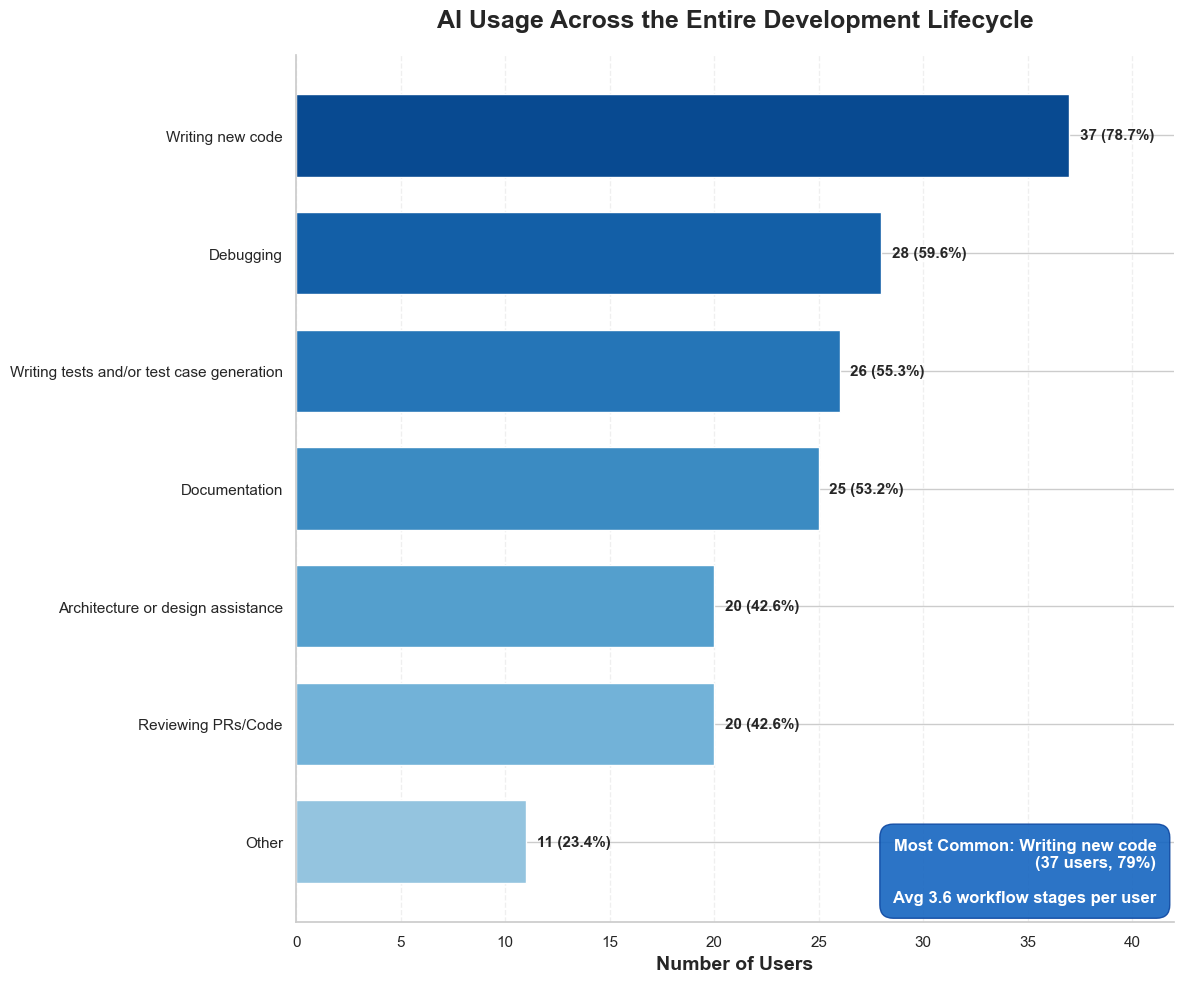


🔄 Workflow Stage Usage Summary:
                           Workflow Stage  Count  Percentage
                         Writing new code     37   78.723404
                                Debugging     28   59.574468
Writing tests and/or test case generation     26   55.319149
                            Documentation     25   53.191489
                       Reviewing PRs/Code     20   42.553191
        Architecture or design assistance     20   42.553191
                                    Other     11   23.404255

📊 Total survey respondents: 47
📈 Total workflow stage selections: 167
💡 Average workflow stages per user: 3.6

✨ Key Insight: AI is being used across 7 different stages of development


In [ ]:

# Get the workflow column
workflow_col = 'Where do you primarily use AI in your development workflow? (Select all that apply)'

# Parse the multi-select responses (comma-separated values)
all_workflows = []
for response in df[workflow_col].dropna():
    # Split by comma and strip whitespace
    workflows = [workflow.strip() for workflow in response.split(',')]
    all_workflows.extend(workflows)

# Count each workflow stage
from collections import Counter
workflow_counts = Counter(all_workflows)

# Convert to DataFrame for easier plotting
workflow_df = pd.DataFrame(workflow_counts.items(), columns=['Workflow Stage', 'Count'])
workflow_df = workflow_df.sort_values('Count', ascending=True)  # Sort for horizontal bar chart

# Calculate percentages
total_responses = len(df)
workflow_df['Percentage'] = (workflow_df['Count'] / total_responses) * 100

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Create color gradient based on usage
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(workflow_df)))

# Create horizontal bar chart
bars = ax.barh(workflow_df['Workflow Stage'], workflow_df['Count'], color=colors, height=0.7)

# Add value labels on the bars
for i, (bar, count, pct) in enumerate(zip(bars, workflow_df['Count'], workflow_df['Percentage'])):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{int(count)} ({pct:.1f}%)', 
            va='center', fontsize=11, weight='bold')

# Customize the plot
ax.set_xlabel('Number of Users', fontsize=14, weight='bold')
ax.set_title('AI Usage Across the Entire Development Lifecycle', 
             fontsize=18, weight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, max(workflow_df['Count']) + 5)

# Add grid for readability
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add insight box
top_stage = workflow_df.nlargest(1, 'Count').iloc[0]
avg_stages_per_user = len(all_workflows) / total_responses

insight_text = f"Most Common: {top_stage['Workflow Stage']}\n"
insight_text += f"({int(top_stage['Count'])} users, {top_stage['Percentage']:.0f}%)\n\n"
insight_text += f"Avg {avg_stages_per_user:.1f} workflow stages per user"

plt.text(0.98, 0.02, insight_text.strip(), 
         transform=ax.transAxes,
         ha='right', 
         va='bottom',
         fontsize=12, 
         weight='bold',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='#1565C0', edgecolor='#0D47A1', alpha=0.9),
         color='white')

plt.tight_layout()
plt.show()

# Print summary
print("\n🔄 Workflow Stage Usage Summary:")
print(workflow_df.sort_values('Count', ascending=False).to_string(index=False))
print(f"\n📊 Total survey respondents: {total_responses}")
print(f"📈 Total workflow stage selections: {len(all_workflows)}")
print(f"💡 Average workflow stages per user: {avg_stages_per_user:.1f}")
print(f"\n✨ Key Insight: AI is being used across {len(workflow_counts)} different stages of development")

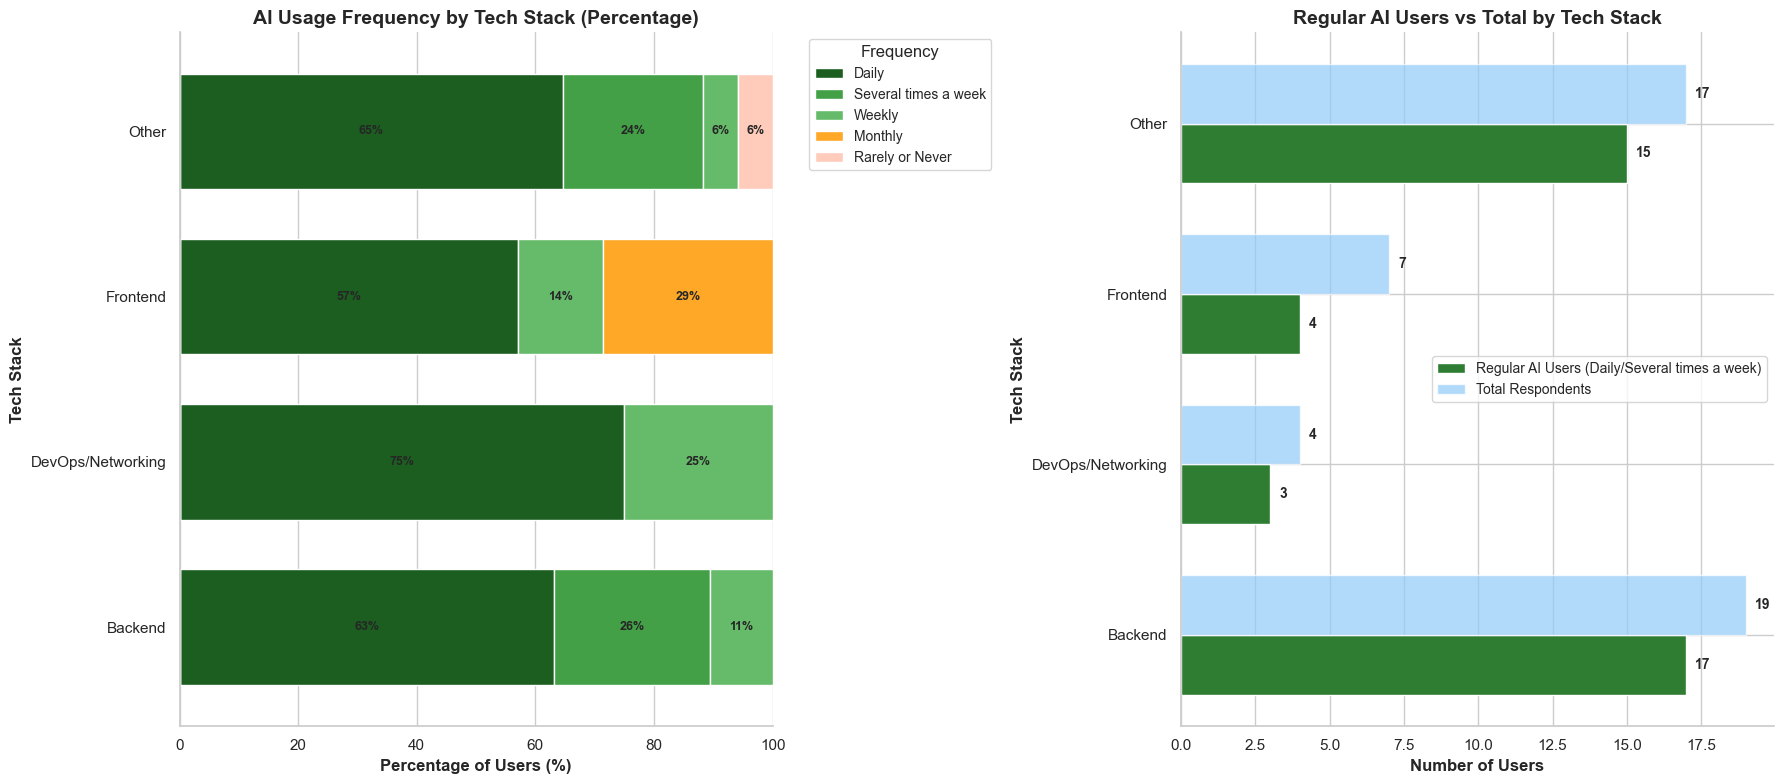


💻 AI Usage Frequency by Tech Stack:

Raw Counts:
How frequently do you currently use AI tools/models in your development process?  Daily  \
Where do you primarily work in the tech stack                                             
Backend                                                                              12   
DevOps/Networking                                                                     3   
Frontend                                                                              4   
Other                                                                                11   

How frequently do you currently use AI tools/models in your development process?  Several times a week  \
Where do you primarily work in the tech stack                                                            
Backend                                                                                              5   
DevOps/Networking                                                                    

In [ ]:
# Get the relevant columns
tech_stack_col = 'Where do you primarily work in the tech stack'
frequency_col = 'How frequently do you currently use AI tools/models in your development process?'

# Create a crosstab to see frequency by tech stack
tech_frequency = pd.crosstab(df[tech_stack_col], df[frequency_col])

# Define the order we want for frequency (from most to least frequent)
frequency_order = ['Daily', 'Several times a week', 'Weekly', 'Monthly', 'Rarely or Never']

# Reorder columns
tech_frequency = tech_frequency.reindex(columns=frequency_order, fill_value=0)

# Calculate percentage for each tech stack
tech_frequency_pct = tech_frequency.div(tech_frequency.sum(axis=1), axis=0) * 100

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Define colors for each frequency level
colors = ['#1B5E20', '#43A047', '#66BB6A', '#FFA726', '#FFCCBC']

# Plot 1: Stacked bar chart (percentages)
tech_frequency_pct.plot(kind='barh', stacked=True, ax=ax1, color=colors, width=0.7)
ax1.set_xlabel('Percentage of Users (%)', fontsize=12, weight='bold')
ax1.set_ylabel('Tech Stack', fontsize=12, weight='bold')
ax1.set_title('AI Usage Frequency by Tech Stack (Percentage)', fontsize=14, weight='bold')
ax1.legend(title='Frequency', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.set_xlim(0, 100)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add percentage labels on stacked bars
for container in ax1.containers:
    labels = [f'{v:.0f}%' if v > 5 else '' for v in container.datavalues]
    ax1.bar_label(container, labels=labels, label_type='center', fontsize=9, weight='bold')

# Plot 2: Grouped bar chart (counts) - showing Daily + Several times a week
regular_usage = tech_frequency[['Daily', 'Several times a week']].sum(axis=1)
total_per_stack = tech_frequency.sum(axis=1)
regular_pct = (regular_usage / total_per_stack * 100)

# Create DataFrame for plotting
comparison_df = pd.DataFrame({
    'Regular Users': regular_usage,
    'Total': total_per_stack
})

# Plot grouped bars
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax2.barh(x - width/2, comparison_df['Regular Users'], width, 
                 label='Regular AI Users (Daily/Several times a week)', color='#2E7D32')
bars2 = ax2.barh(x + width/2, comparison_df['Total'], width, 
                 label='Total Respondents', color='#90CAF9', alpha=0.7)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        ax2.text(width_val + 0.3, bar.get_y() + bar.get_height()/2, 
                f'{int(width_val)}', 
                va='center', fontsize=10, weight='bold')

ax2.set_ylabel('Tech Stack', fontsize=12, weight='bold')
ax2.set_xlabel('Number of Users', fontsize=12, weight='bold')
ax2.set_title('Regular AI Users vs Total by Tech Stack', fontsize=14, weight='bold')
ax2.set_yticks(x)
ax2.set_yticklabels(comparison_df.index)
ax2.legend(fontsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print detailed summary
print("\n💻 AI Usage Frequency by Tech Stack:")
print("\nRaw Counts:")
print(tech_frequency)
print("\n" + "="*80)
print("\nPercentages:")
print(tech_frequency_pct.round(1))
print("\n" + "="*80)
print("\n📊 Regular AI Users (Daily + Several times a week) by Tech Stack:")
for stack in comparison_df.index:
    reg = comparison_df.loc[stack, 'Regular Users']
    tot = comparison_df.loc[stack, 'Total']
    pct = (reg / tot * 100) if tot > 0 else 0
    print(f"  {stack}: {int(reg)}/{int(tot)} ({pct:.1f}%)")

# Calculate overall stats
overall_daily = tech_frequency['Daily'].sum()
overall_several = tech_frequency['Several times a week'].sum()
overall_total = tech_frequency.sum().sum()
overall_regular_pct = ((overall_daily + overall_several) / overall_total * 100)

print(f"\n✨ Overall: {overall_daily + overall_several}/{overall_total} ({overall_regular_pct:.1f}%) are regular AI users")

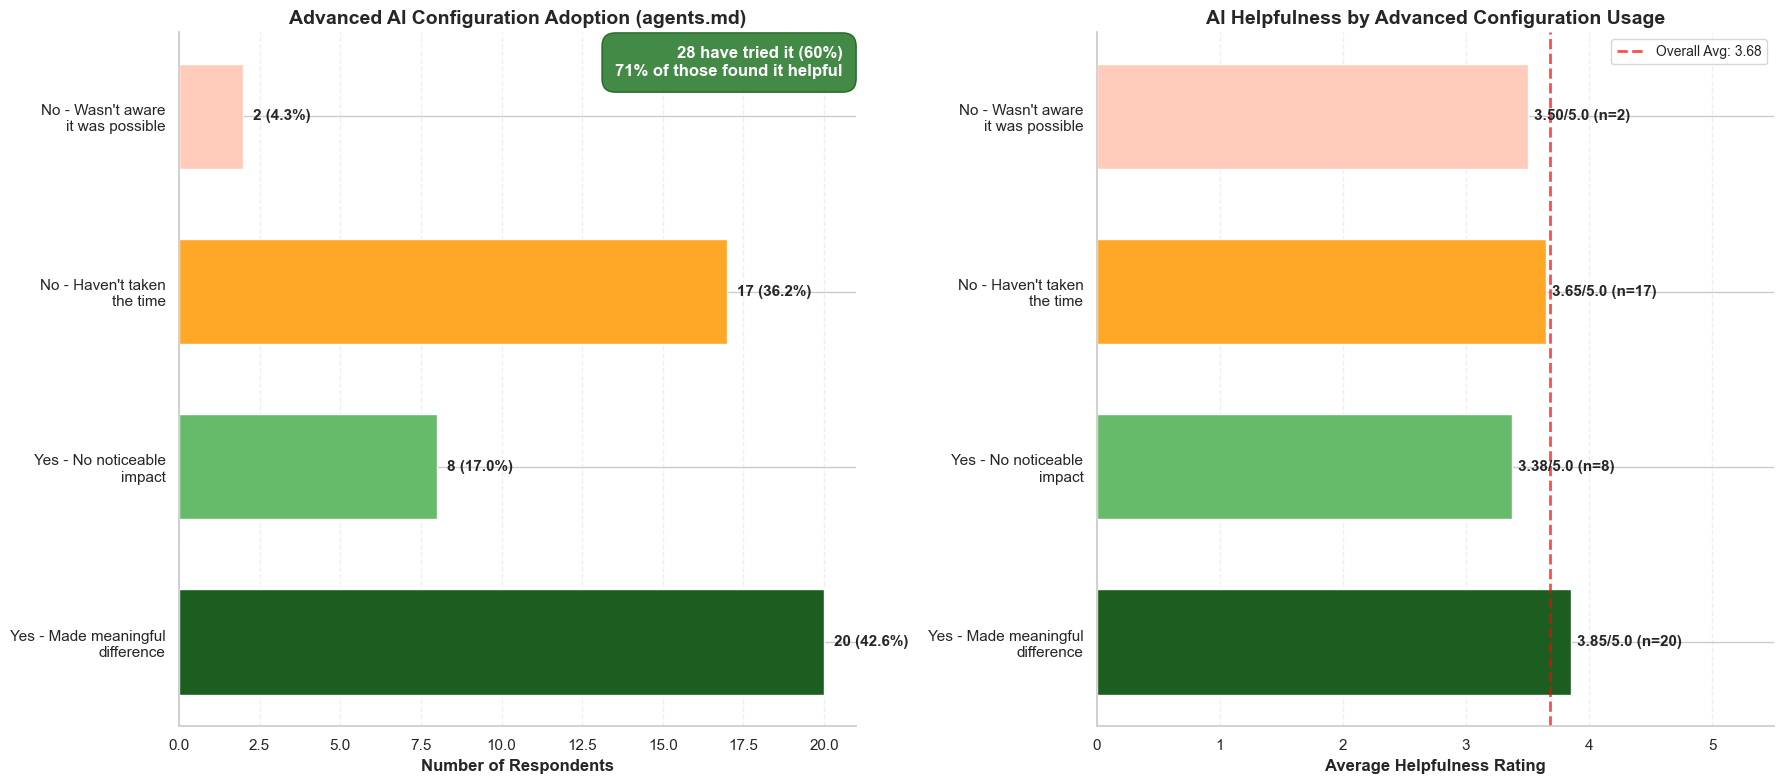


🚀 Advanced AI Configuration (agents.md) Analysis:


Adoption Breakdown:
  Yes -- and it made a meaningful difference
    Count: 20 (42.6%)
  Yes -- but I didn't notice much impact
    Count: 8 (17.0%)
  No -- I know it's possible but haven't taken the time
    Count: 17 (36.2%)
  No -- I wasn't aware that was possible
    Count: 2 (4.3%)


Average Helpfulness Rating by agents.md Usage:
  Yes -- and it made a meaningful difference
    Average: 3.85/5.0 (n=20)
  Yes -- but I didn't notice much impact
    Average: 3.38/5.0 (n=8)
  No -- I know it's possible but haven't taken the time
    Average: 3.65/5.0 (n=17)
  No -- I wasn't aware that was possible
    Average: 3.50/5.0 (n=2)


✨ Key Insights:
  • 28 people (59.6%) have tried advanced configuration
  • 71% of those who tried found it made a meaningful difference
  • Those who found it helpful rate AI at 3.85/5.0
  • Overall average helpfulness: 3.68/5.0


In [ ]:
# Get the relevant columns
agents_col = 'Have you ever written an `agents.md`, modified your `.claude` directory, or added context specifically for agents in other way?'
helpfulness_col = 'On a scale of 1 to 5, how would you rate the overall helpfulness of AI in your daily development tasks?'

# Count the agents.md responses
agents_counts = df[agents_col].value_counts()

# Define the order we want
agents_order = [
    'Yes -- and it made a meaningful difference',
    'Yes -- but I didn\'t notice much impact',
    'No -- I know it\'s possible but haven\'t taken the time',
    'No -- I wasn\'t aware that was possible'
]

# Reindex to get consistent ordering
agents_counts = agents_counts.reindex(agents_order, fill_value=0)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# ===== LEFT CHART: Overall adoption breakdown =====
colors = ['#1B5E20', '#66BB6A', '#FFA726', '#FFCCBC']
bars = ax1.barh(range(len(agents_counts)), agents_counts.values, color=colors, height=0.6)

# Add value labels
for i, (bar, count) in enumerate(zip(bars, agents_counts.values)):
    percentage = (count / len(df)) * 100
    ax1.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
            f'{int(count)} ({percentage:.1f}%)', 
            va='center', fontsize=11, weight='bold')

# Wrap long labels
wrapped_labels = [
    'Yes - Made meaningful\ndifference',
    'Yes - No noticeable\nimpact',
    'No - Haven\'t taken\nthe time',
    'No - Wasn\'t aware\nit was possible'
]

ax1.set_yticks(range(len(agents_counts)))
ax1.set_yticklabels(wrapped_labels, fontsize=11)
ax1.set_xlabel('Number of Respondents', fontsize=12, weight='bold')
ax1.set_title('Advanced AI Configuration Adoption (agents.md)', fontsize=14, weight='bold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Calculate key stats
tried_it = agents_counts.iloc[0] + agents_counts.iloc[1]
found_helpful = agents_counts.iloc[0]
tried_percentage = (tried_it / len(df)) * 100
helpful_percentage = (found_helpful / tried_it * 100) if tried_it > 0 else 0

# Add insight box
insight_text = f"{int(tried_it)} have tried it ({tried_percentage:.0f}%)\n"
insight_text += f"{helpful_percentage:.0f}% of those found it helpful"

ax1.text(0.98, 0.98, insight_text.strip(), 
         transform=ax1.transAxes,
         ha='right', 
         va='top',
         fontsize=12, 
         weight='bold',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='#2E7D32', edgecolor='#1B5E20', alpha=0.9),
         color='white')

# ===== RIGHT CHART: Helpfulness by agents.md status =====
# Create a mapping for helpfulness ratings to numeric
rating_values = {
    'Extremely Helpful': 5, 
    'Very Helpful': 4, 
    'Moderately Helpful': 3, 
    'Slightly Helpful': 2, 
    'Not Helpful': 1
}

df['rating_numeric'] = df[helpfulness_col].map(rating_values)

# Calculate average helpfulness for each agents.md response
avg_by_agents = df.groupby(agents_col)['rating_numeric'].agg(['mean', 'count'])
avg_by_agents = avg_by_agents.reindex(agents_order)

# Create grouped bar chart
x_pos = np.arange(len(agents_order))
bars2 = ax2.barh(x_pos, avg_by_agents['mean'], color=colors, height=0.6)

# Add value labels
for i, (bar, avg, count) in enumerate(zip(bars2, avg_by_agents['mean'], avg_by_agents['count'])):
    ax2.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
            f'{avg:.2f}/5.0 (n={int(count)})', 
            va='center', fontsize=11, weight='bold')

ax2.set_yticks(x_pos)
ax2.set_yticklabels(wrapped_labels, fontsize=11)
ax2.set_xlabel('Average Helpfulness Rating', fontsize=12, weight='bold')
ax2.set_title('AI Helpfulness by Advanced Configuration Usage', fontsize=14, weight='bold')
ax2.set_xlim(0, 5.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add reference line for overall average
overall_avg = df['rating_numeric'].mean()
ax2.axvline(overall_avg, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Overall Avg: {overall_avg:.2f}')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed summary
print("\n🚀 Advanced AI Configuration (agents.md) Analysis:")
print("\n" + "="*80)
print("\nAdoption Breakdown:")
for i, (response, count) in enumerate(zip(agents_order, agents_counts.values)):
    percentage = (count / len(df)) * 100
    print(f"  {response}")
    print(f"    Count: {int(count)} ({percentage:.1f}%)")

print("\n" + "="*80)
print("\nAverage Helpfulness Rating by agents.md Usage:")
for response in agents_order:
    avg = avg_by_agents.loc[response, 'mean']
    count = avg_by_agents.loc[response, 'count']
    print(f"  {response}")
    print(f"    Average: {avg:.2f}/5.0 (n={int(count)})")

print("\n" + "="*80)
print(f"\n✨ Key Insights:")
print(f"  • {int(tried_it)} people ({tried_percentage:.1f}%) have tried advanced configuration")
print(f"  • {helpful_percentage:.0f}% of those who tried found it made a meaningful difference")
print(f"  • Those who found it helpful rate AI at {avg_by_agents.loc[agents_order[0], 'mean']:.2f}/5.0")
print(f"  • Overall average helpfulness: {overall_avg:.2f}/5.0")

/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/3641150279.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


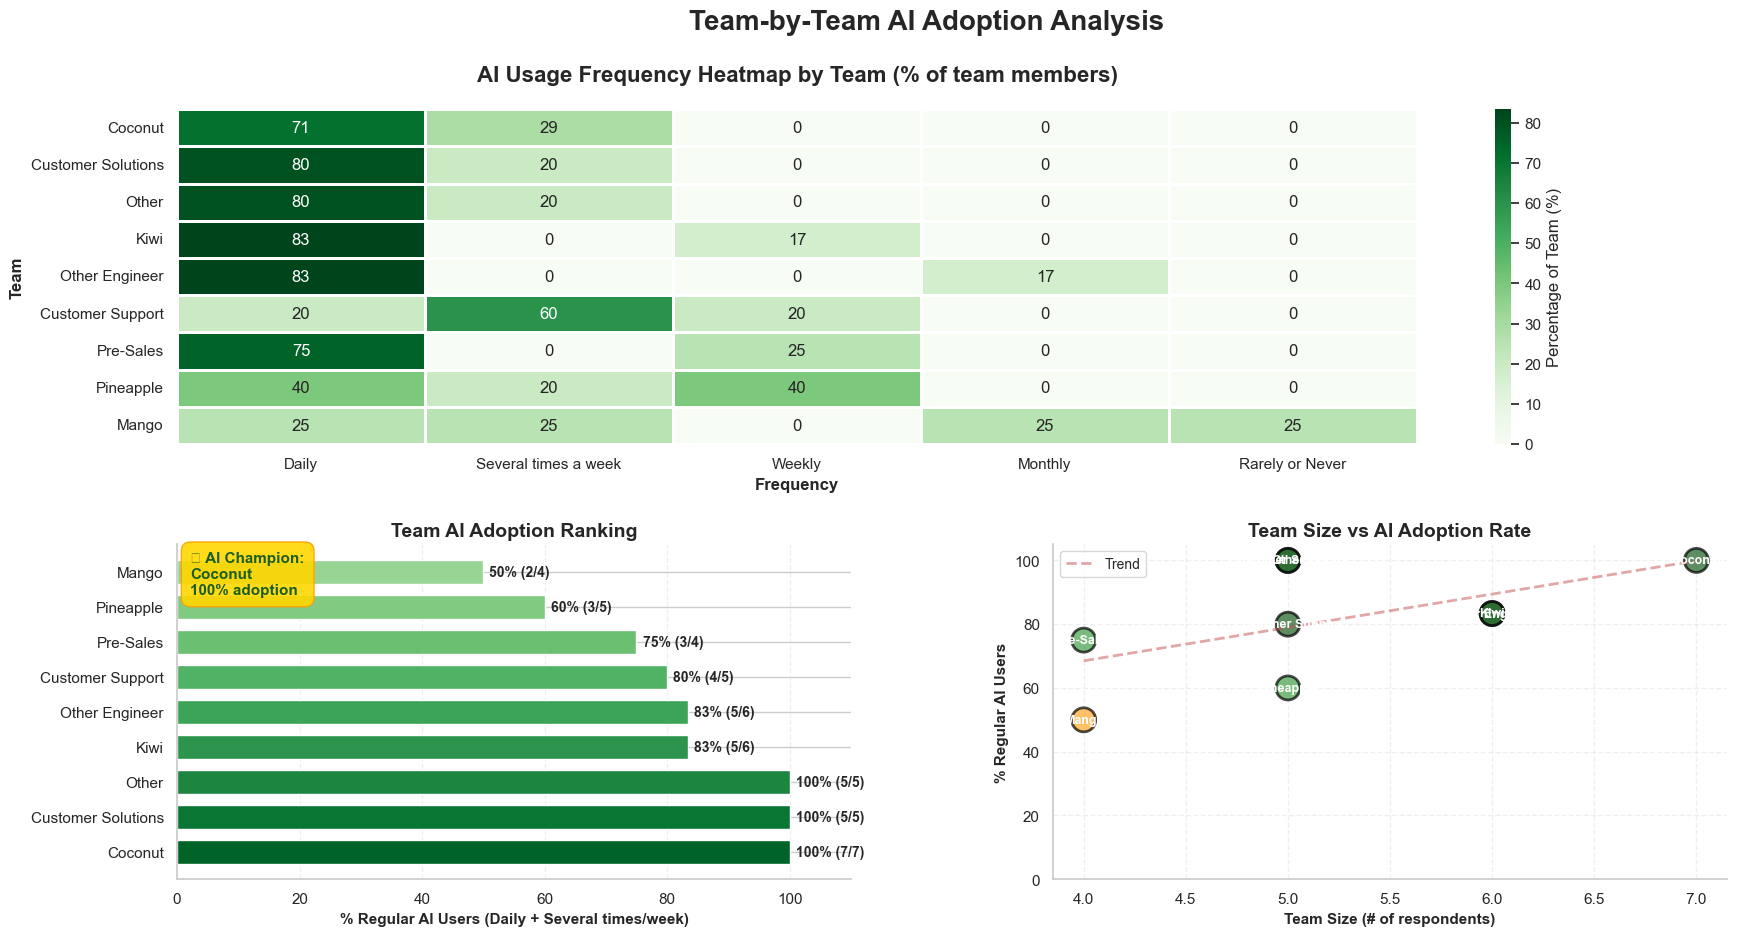


🏆 Team AI Adoption Rankings:

Team                    Total    Daily  Regular    Regular %    Avg Score
Coconut                     7        5        7       100.0%        4.71/5
Customer Solutions          5        4        5       100.0%        4.80/5
Other                       5        4        5       100.0%        4.80/5
Kiwi                        6        5        5        83.3%        4.67/5
Other Engineer              6        5        5        83.3%        4.50/5
Customer Support            5        1        4        80.0%        4.00/5
Pre-Sales                   4        3        3        75.0%        4.50/5
Pineapple                   5        2        3        60.0%        4.00/5
Mango                       4        1        2        50.0%        3.00/5


🥇 Top 3 Teams by AI Adoption:
🥇 Coconut: 100% regular adoption (7/7 members)
🥈 Customer Solutions: 100% regular adoption (5/5 members)
🥉 Other: 100% regular adoption (5/5 members)

✨ Key Insights:
  • Top 3 teams avera

In [ ]:
# Get the relevant columns
team_col = 'Which team are you a part of?'
frequency_col = 'How frequently do you currently use AI tools/models in your development process?'

# Create a crosstab to see frequency by team
team_frequency = pd.crosstab(df[team_col], df[frequency_col])

# Define the order we want for frequency (from most to least frequent)
frequency_order = ['Daily', 'Several times a week', 'Weekly', 'Monthly', 'Rarely or Never']

# Reorder columns
team_frequency = team_frequency.reindex(columns=frequency_order, fill_value=0)

# Calculate metrics for ranking teams
team_metrics = pd.DataFrame()
team_metrics['Total'] = team_frequency.sum(axis=1)
team_metrics['Daily'] = team_frequency['Daily']
team_metrics['Regular Users'] = team_frequency['Daily'] + team_frequency['Several times a week']
team_metrics['Regular %'] = (team_metrics['Regular Users'] / team_metrics['Total'] * 100)
team_metrics['Avg Score'] = (
    team_frequency['Daily'] * 5 + 
    team_frequency['Several times a week'] * 4 + 
    team_frequency['Weekly'] * 3 + 
    team_frequency['Monthly'] * 2 + 
    team_frequency['Rarely or Never'] * 1
) / team_metrics['Total']

# Sort by regular usage percentage
team_metrics = team_metrics.sort_values('Regular %', ascending=False)

# Reorder team_frequency to match
team_frequency = team_frequency.reindex(team_metrics.index)

# Create figure with three subplots
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(gs[0, :])  # Top: full width heatmap
ax2 = fig.add_subplot(gs[1, 0])  # Bottom left: ranking
ax3 = fig.add_subplot(gs[1, 1])  # Bottom right: team size vs adoption

# ===== TOP CHART: Heatmap of frequency by team =====
# Create percentage-based heatmap
team_frequency_pct = team_frequency.div(team_frequency.sum(axis=1), axis=0) * 100

sns.heatmap(team_frequency_pct, annot=True, fmt='.0f', cmap='Greens', 
            cbar_kws={'label': 'Percentage of Team (%)'}, ax=ax1, linewidths=1, linecolor='white')
ax1.set_title('AI Usage Frequency Heatmap by Team (% of team members)', fontsize=16, weight='bold', pad=20)
ax1.set_xlabel('Frequency', fontsize=12, weight='bold')
ax1.set_ylabel('Team', fontsize=12, weight='bold')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# ===== BOTTOM LEFT: Team ranking by adoption =====
colors_ranking = plt.cm.Greens(np.linspace(0.9, 0.4, len(team_metrics)))
bars = ax2.barh(range(len(team_metrics)), team_metrics['Regular %'], color=colors_ranking, height=0.7)

# Add value labels
for i, (bar, pct, total, regular) in enumerate(zip(bars, team_metrics['Regular %'], 
                                                     team_metrics['Total'], team_metrics['Regular Users'])):
    ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{pct:.0f}% ({int(regular)}/{int(total)})', 
            va='center', fontsize=10, weight='bold')

ax2.set_yticks(range(len(team_metrics)))
ax2.set_yticklabels(team_metrics.index, fontsize=11)
ax2.set_xlabel('% Regular AI Users (Daily + Several times/week)', fontsize=11, weight='bold')
ax2.set_title('Team AI Adoption Ranking', fontsize=14, weight='bold')
ax2.set_xlim(0, 110)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add champion badge to top team
top_team = team_metrics.index[0]
top_pct = team_metrics['Regular %'].iloc[0]
badge_text = f"🏆 AI Champion:\n{top_team}\n{top_pct:.0f}% adoption"
ax2.text(0.02, 0.98, badge_text, 
         transform=ax2.transAxes,
         ha='left', 
         va='top',
         fontsize=11, 
         weight='bold',
         bbox=dict(boxstyle='round,pad=0.6', facecolor='#FFD700', edgecolor='#FFA000', alpha=0.9),
         color='#1B5E20')

# ===== BOTTOM RIGHT: Team size vs adoption scatter plot =====
scatter_colors = ['#1B5E20' if pct >= 80 else '#43A047' if pct >= 60 else '#FFA726' 
                  for pct in team_metrics['Regular %']]

ax3.scatter(team_metrics['Total'], team_metrics['Regular %'], 
           s=300, c=scatter_colors, alpha=0.7, edgecolors='black', linewidth=2)

# Add team labels
for idx, row in team_metrics.iterrows():
    ax3.annotate(idx, (row['Total'], row['Regular %']), 
                ha='center', va='center', fontsize=9, weight='bold', color='white')

ax3.set_xlabel('Team Size (# of respondents)', fontsize=11, weight='bold')
ax3.set_ylabel('% Regular AI Users', fontsize=11, weight='bold')
ax3.set_title('Team Size vs AI Adoption Rate', fontsize=14, weight='bold')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.grid(alpha=0.3, linestyle='--')
ax3.set_ylim(0, 105)

# Add trend line
z = np.polyfit(team_metrics['Total'], team_metrics['Regular %'], 1)
p = np.poly1d(z)
x_trend = np.linspace(team_metrics['Total'].min(), team_metrics['Total'].max(), 100)
ax3.plot(x_trend, p(x_trend), "r--", alpha=0.5, linewidth=2, label='Trend')
ax3.legend(fontsize=10)

plt.suptitle('Team-by-Team AI Adoption Analysis', fontsize=20, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print detailed summary
print("\n🏆 Team AI Adoption Rankings:")
print("\n" + "="*80)
print(f"{'Team':<20} {'Total':>8} {'Daily':>8} {'Regular':>8} {'Regular %':>12} {'Avg Score':>12}")
print("="*80)
for idx, row in team_metrics.iterrows():
    print(f"{idx:<20} {int(row['Total']):>8} {int(row['Daily']):>8} {int(row['Regular Users']):>8} "
          f"{row['Regular %']:>11.1f}% {row['Avg Score']:>11.2f}/5")

print("\n" + "="*80)
print(f"\n🥇 Top 3 Teams by AI Adoption:")
for i, (idx, row) in enumerate(team_metrics.head(3).iterrows(), 1):
    medals = ['🥇', '🥈', '🥉']
    print(f"{medals[i-1]} {idx}: {row['Regular %']:.0f}% regular adoption ({int(row['Regular Users'])}/{int(row['Total'])} members)")

print(f"\n✨ Key Insights:")
top_3_avg = team_metrics.head(3)['Regular %'].mean()
bottom_3_avg = team_metrics.tail(3)['Regular %'].mean()
print(f"  • Top 3 teams average {top_3_avg:.0f}% regular AI adoption")
print(f"  • Bottom 3 teams average {bottom_3_avg:.0f}% regular AI adoption")
print(f"  • Gap between highest and lowest: {team_metrics['Regular %'].max() - team_metrics['Regular %'].min():.0f} percentage points")

/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/3449138674.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/li

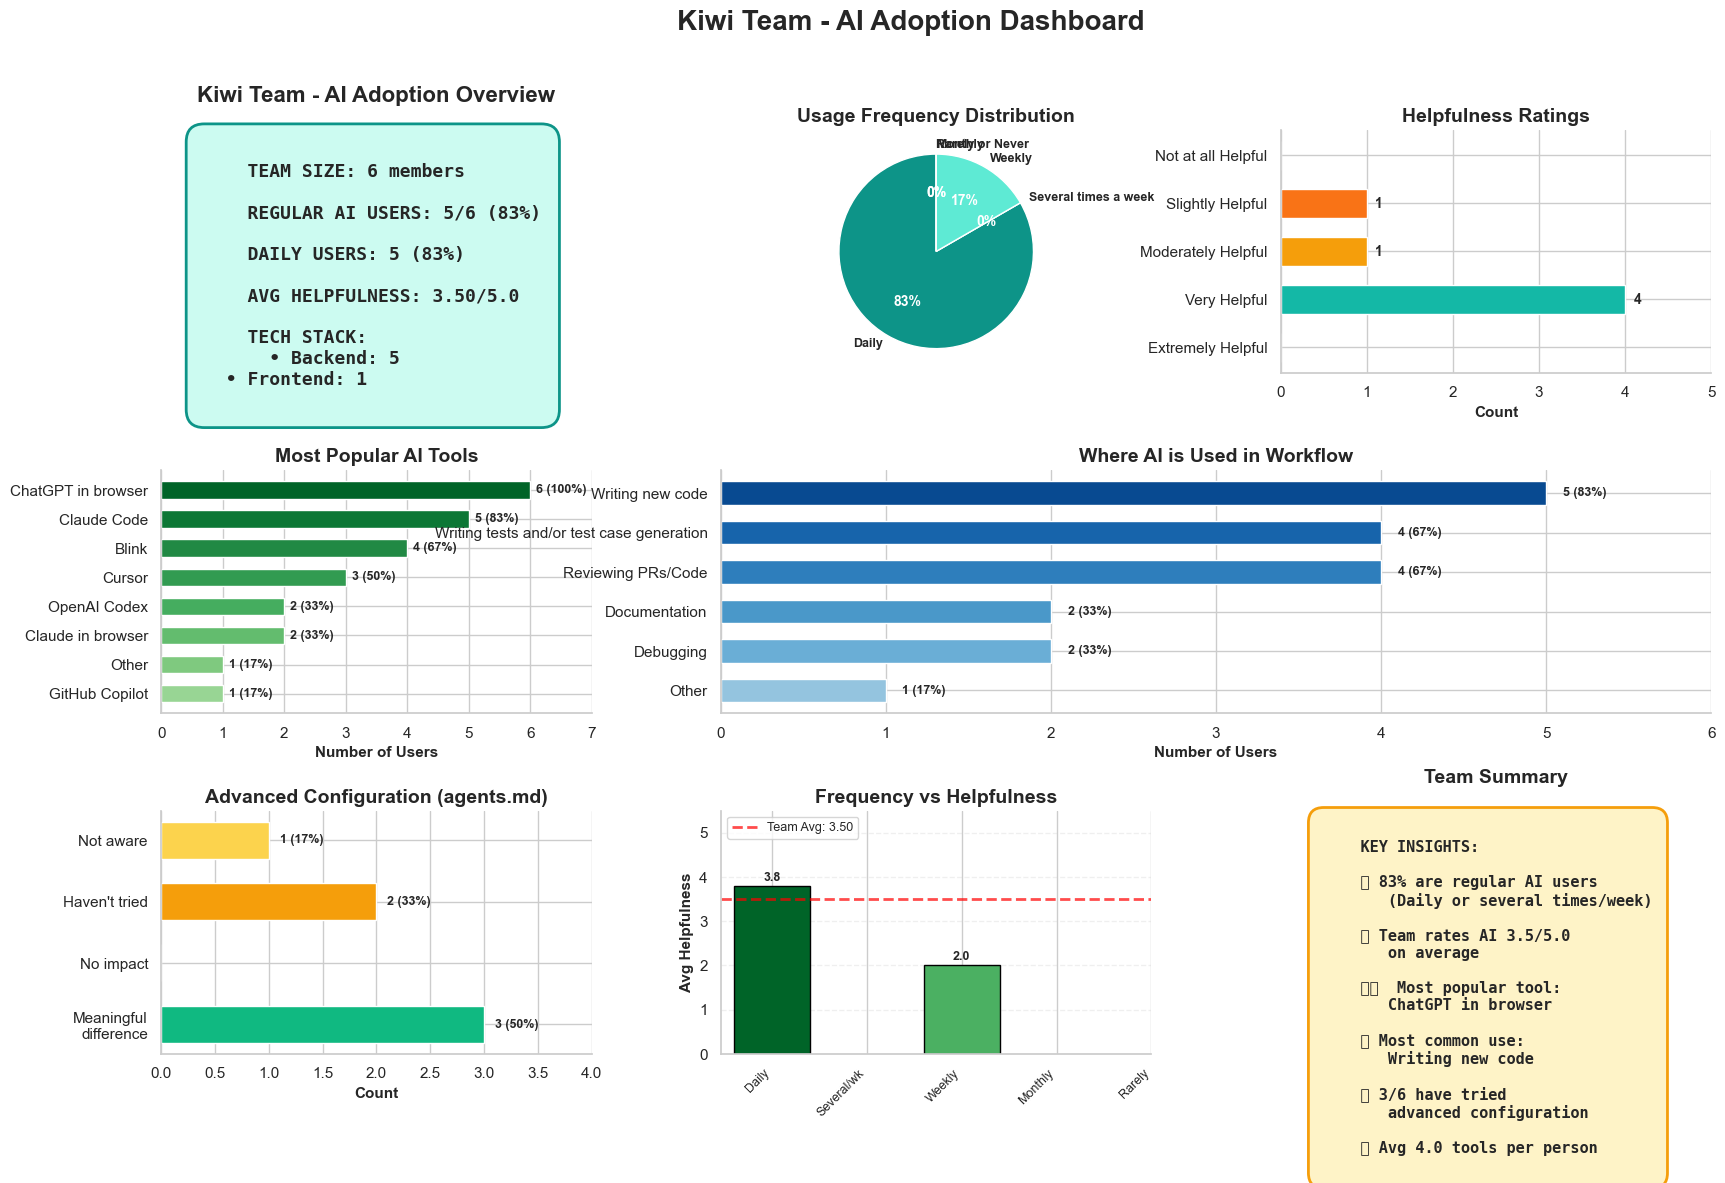


Kiwi TEAM - AI ADOPTION REPORT

📊 Team Composition:
   Total members: 6
   Tech Stack breakdown:
      • Backend: 5 (83%)
      • Frontend: 1 (17%)

🎯 AI Adoption Metrics:
   Regular users (Daily/Several times week): 5/6 (83%)
   Daily users: 5 (83%)
   Average helpfulness rating: 3.50/5.0

🛠️  Top 3 Tools:
   1. ChatGPT in browser: 6 users (100%)
   2. Claude Code: 5 users (83%)
   3. Blink: 4 users (67%)

🔄 Top 3 Workflow Uses:
   1. Writing new code: 5 users (83%)
   2. Writing tests and/or test case generation: 4 users (67%)
   3. Reviewing PRs/Code: 4 users (67%)

🚀 Advanced Configuration:
   Tried agents.md: 3/6 (50%)
   Found it helpful: 3/3




/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/3449138674.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/li

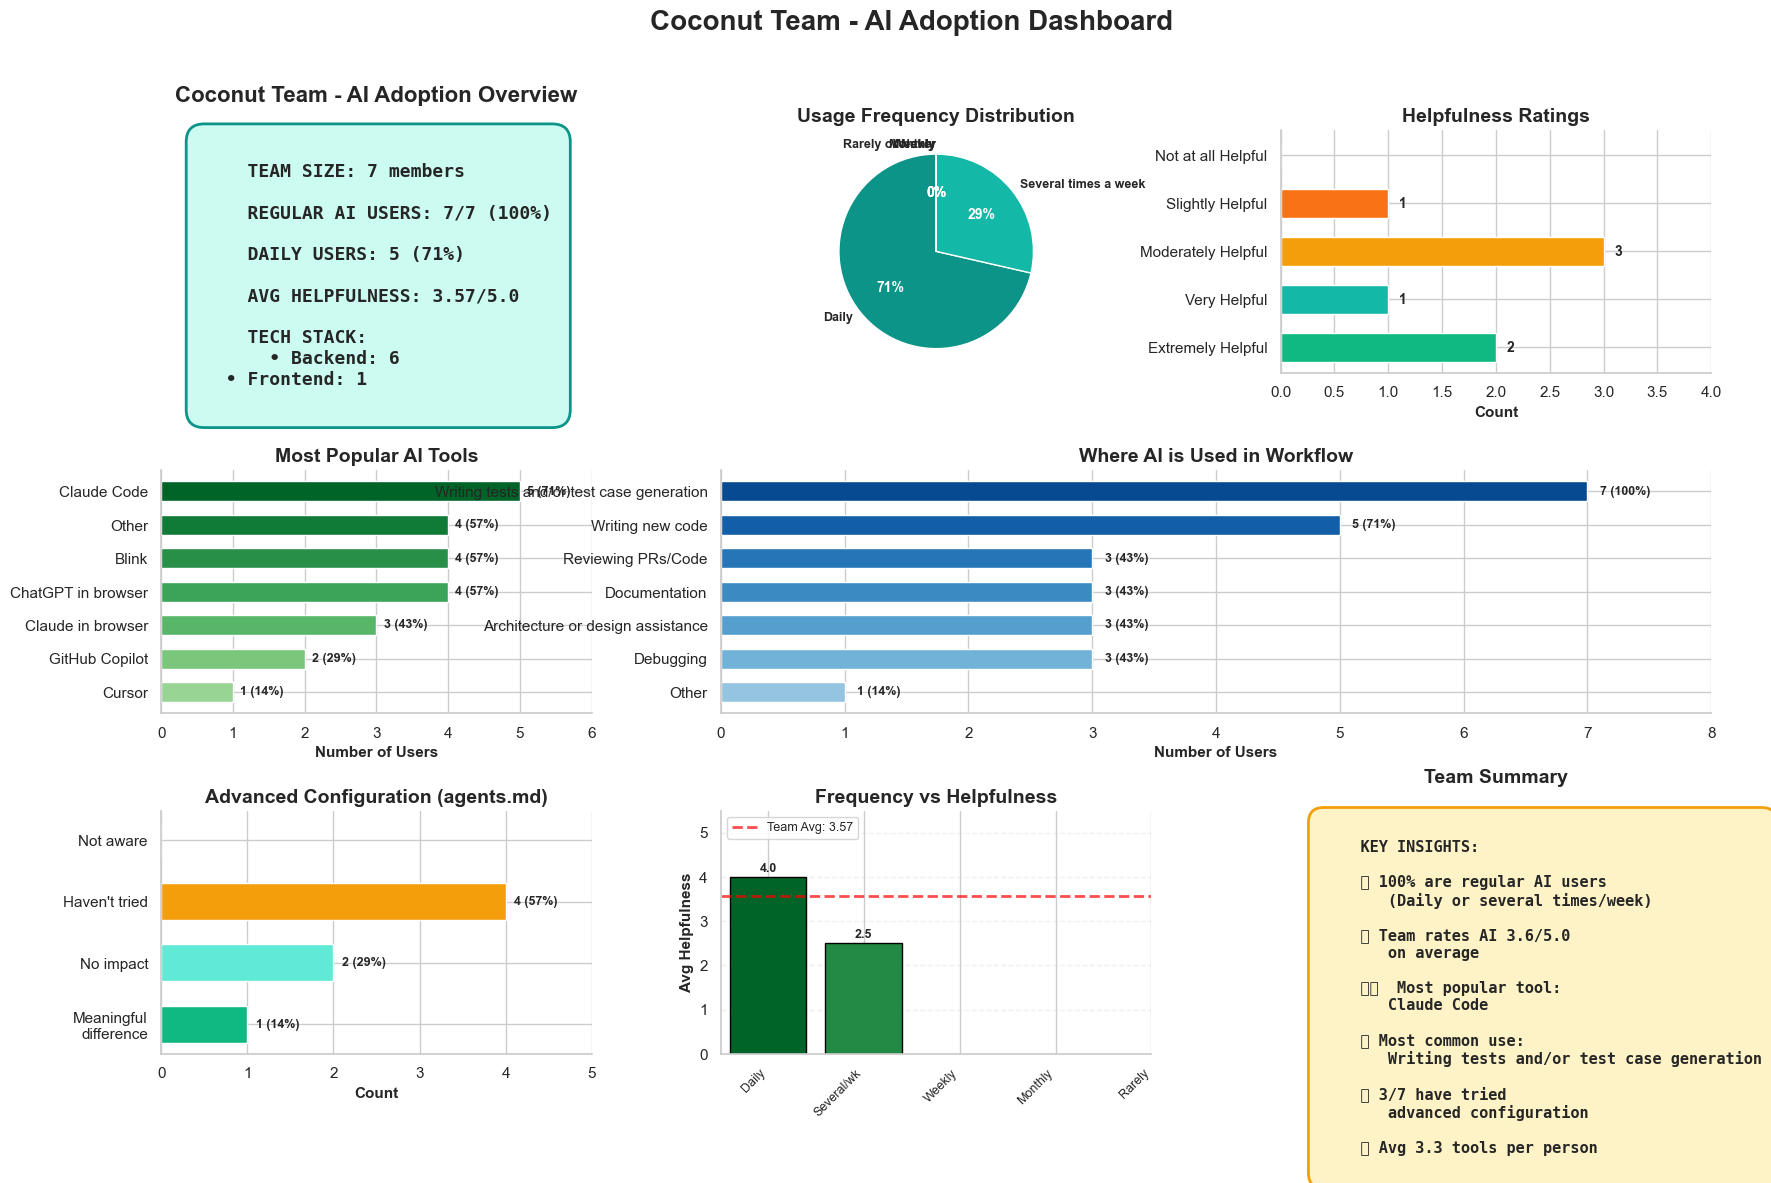


Coconut TEAM - AI ADOPTION REPORT

📊 Team Composition:
   Total members: 7
   Tech Stack breakdown:
      • Backend: 6 (86%)
      • Frontend: 1 (14%)

🎯 AI Adoption Metrics:
   Regular users (Daily/Several times week): 7/7 (100%)
   Daily users: 5 (71%)
   Average helpfulness rating: 3.57/5.0

🛠️  Top 3 Tools:
   1. Claude Code: 5 users (71%)
   2. Other: 4 users (57%)
   3. Blink: 4 users (57%)

🔄 Top 3 Workflow Uses:
   1. Writing tests and/or test case generation: 7 users (100%)
   2. Writing new code: 5 users (71%)
   3. Reviewing PRs/Code: 3 users (43%)

🚀 Advanced Configuration:
   Tried agents.md: 3/7 (43%)
   Found it helpful: 1/3




/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/3449138674.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/li

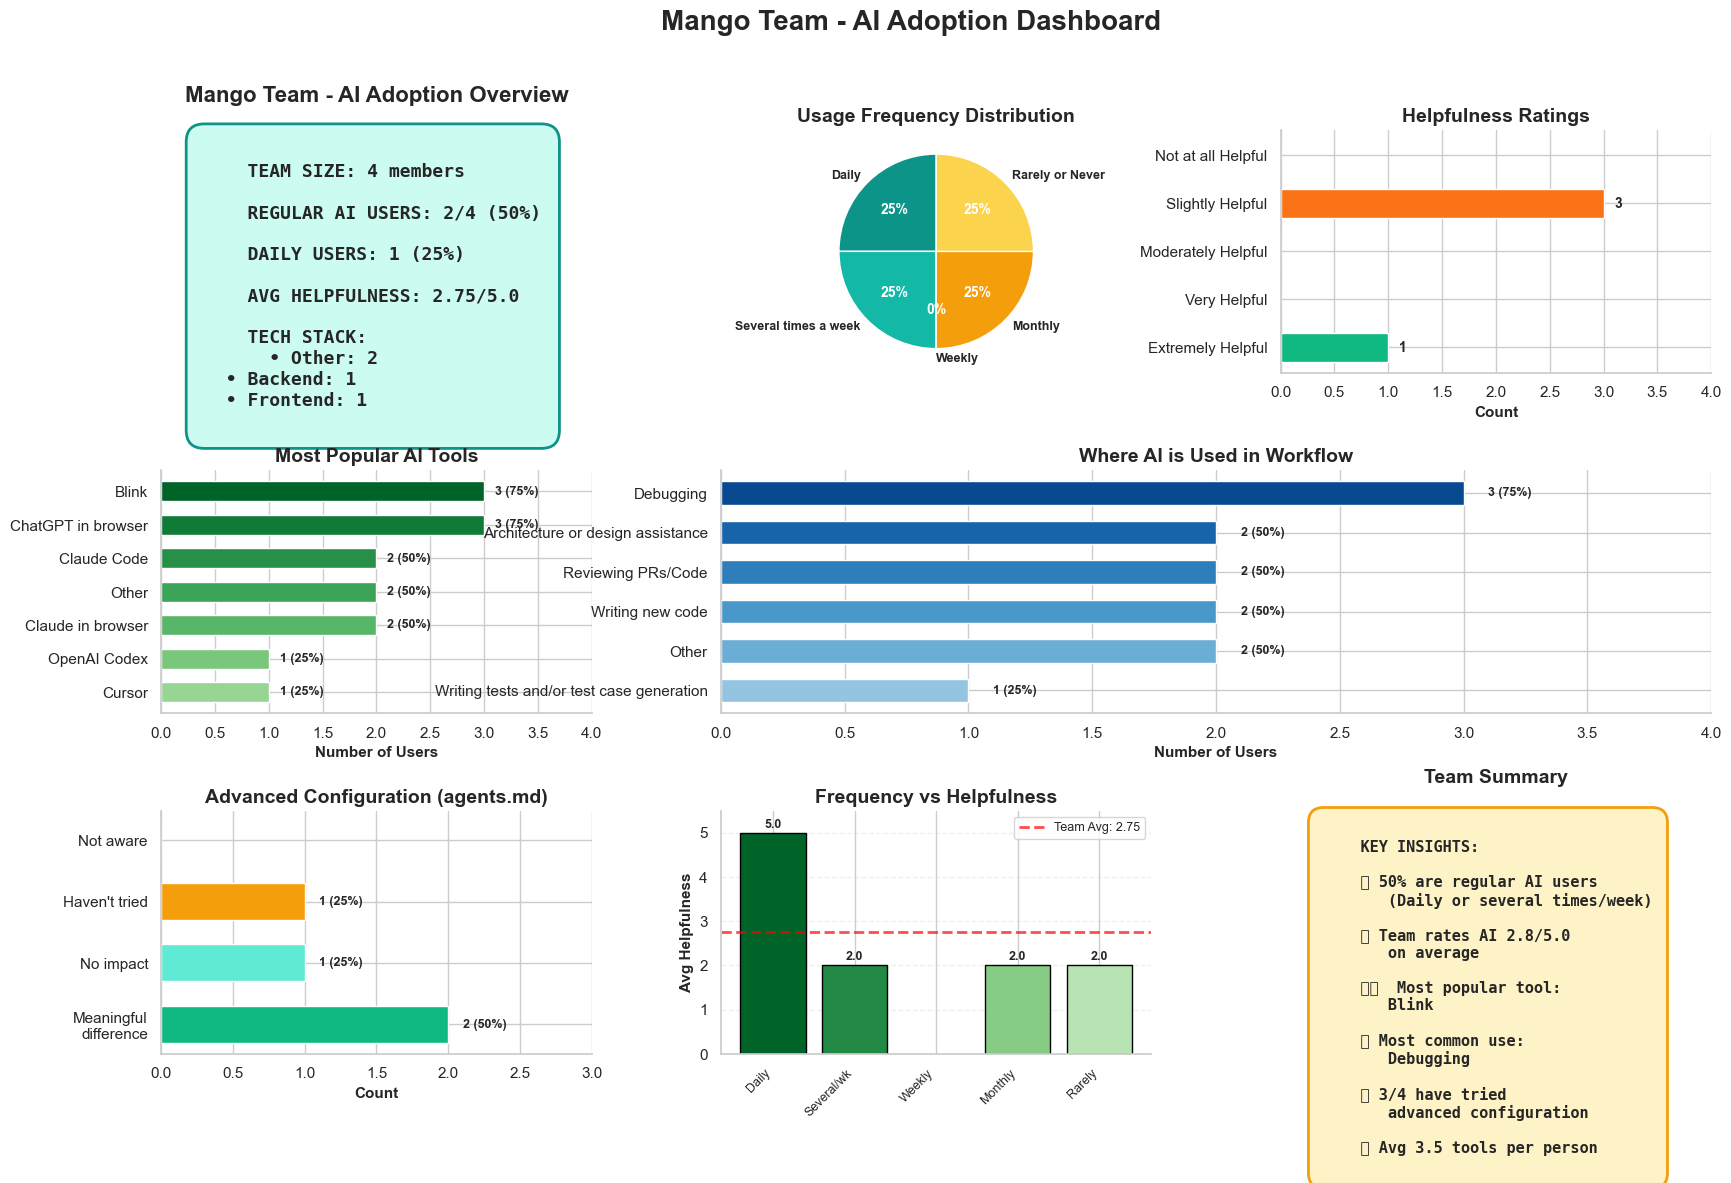


Mango TEAM - AI ADOPTION REPORT

📊 Team Composition:
   Total members: 4
   Tech Stack breakdown:
      • Other: 2 (50%)
      • Backend: 1 (25%)
      • Frontend: 1 (25%)

🎯 AI Adoption Metrics:
   Regular users (Daily/Several times week): 2/4 (50%)
   Daily users: 1 (25%)
   Average helpfulness rating: 2.75/5.0

🛠️  Top 3 Tools:
   1. Blink: 3 users (75%)
   2. ChatGPT in browser: 3 users (75%)
   3. Claude Code: 2 users (50%)

🔄 Top 3 Workflow Uses:
   1. Debugging: 3 users (75%)
   2. Architecture or design assistance: 2 users (50%)
   3. Reviewing PRs/Code: 2 users (50%)

🚀 Advanced Configuration:
   Tried agents.md: 3/4 (75%)
   Found it helpful: 2/3




/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/3449138674.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/li

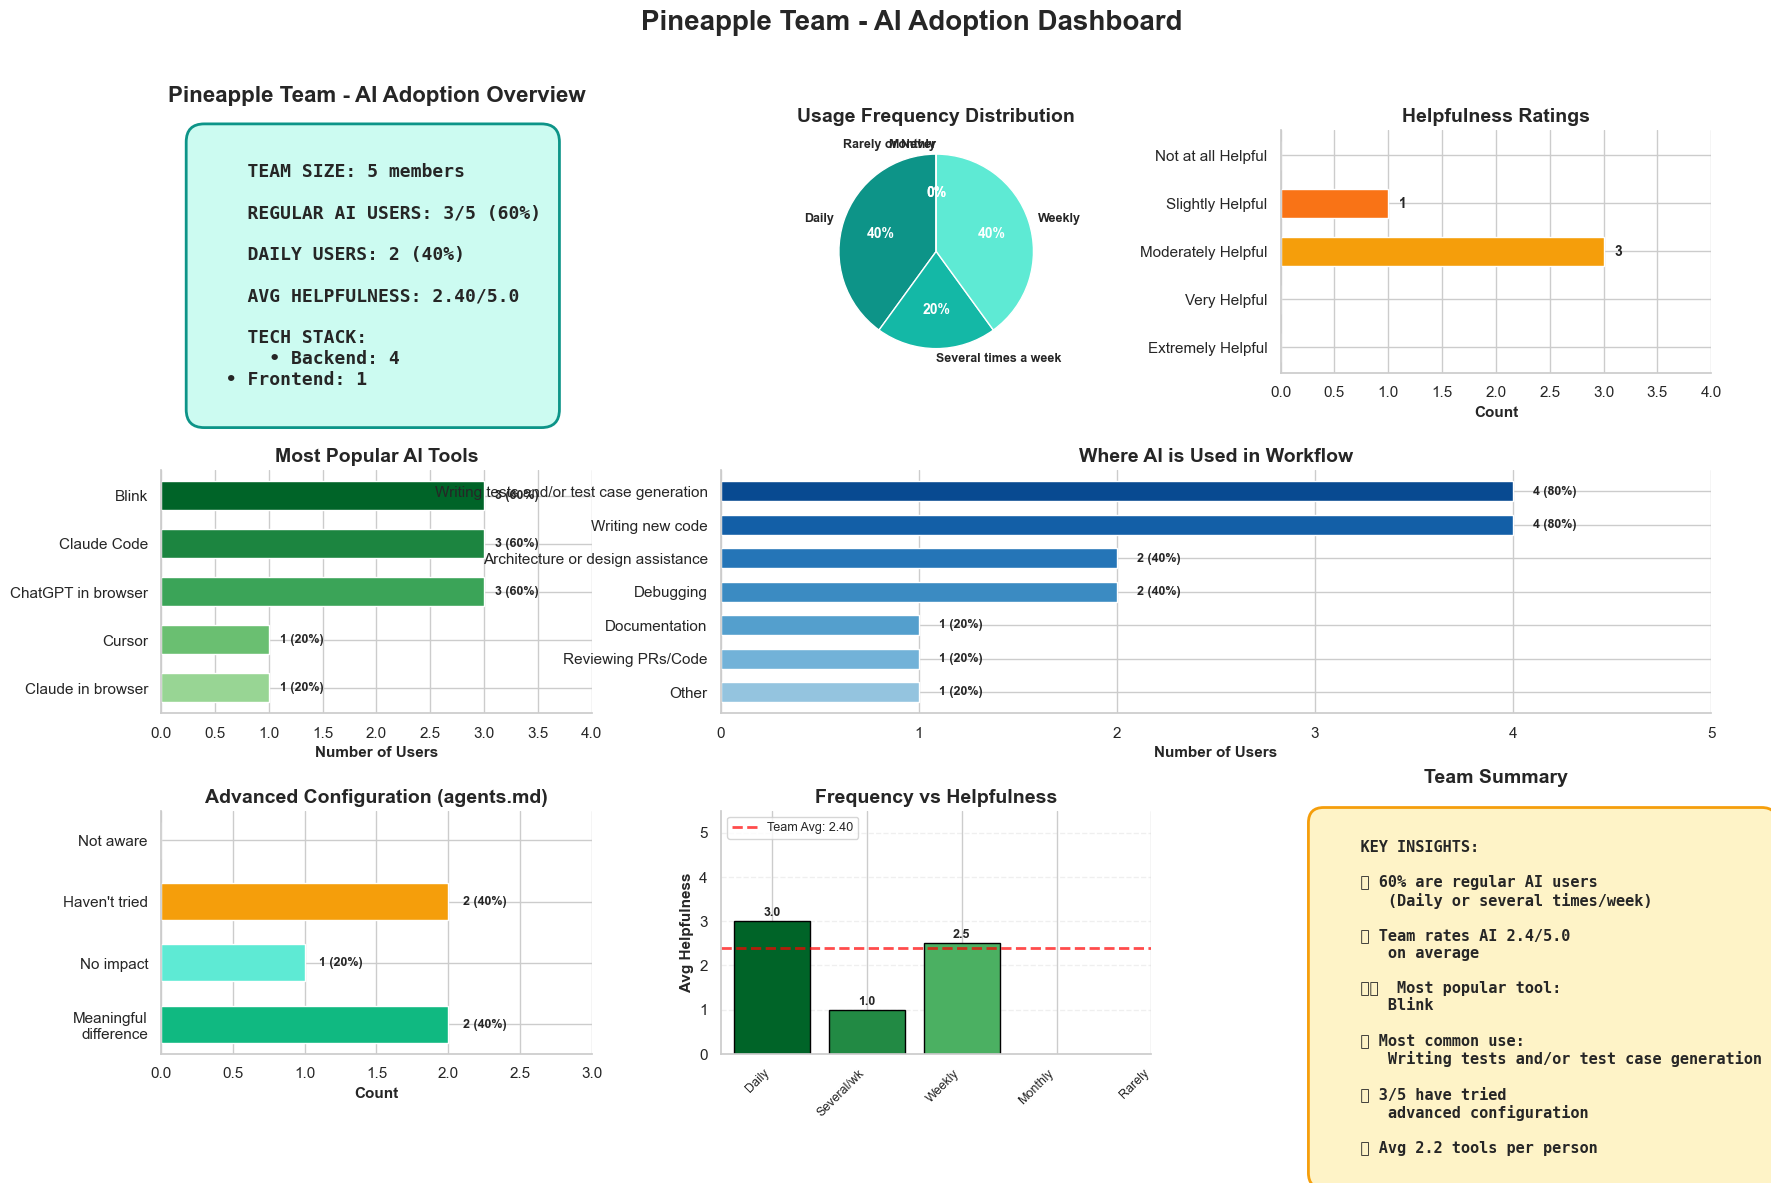


Pineapple TEAM - AI ADOPTION REPORT

📊 Team Composition:
   Total members: 5
   Tech Stack breakdown:
      • Backend: 4 (80%)
      • Frontend: 1 (20%)

🎯 AI Adoption Metrics:
   Regular users (Daily/Several times week): 3/5 (60%)
   Daily users: 2 (40%)
   Average helpfulness rating: 2.40/5.0

🛠️  Top 3 Tools:
   1. Blink: 3 users (60%)
   2. Claude Code: 3 users (60%)
   3. ChatGPT in browser: 3 users (60%)

🔄 Top 3 Workflow Uses:
   1. Writing tests and/or test case generation: 4 users (80%)
   2. Writing new code: 4 users (80%)
   3. Architecture or design assistance: 2 users (40%)

🚀 Advanced Configuration:
   Tried agents.md: 3/5 (60%)
   Found it helpful: 2/3




/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/3449138674.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/li

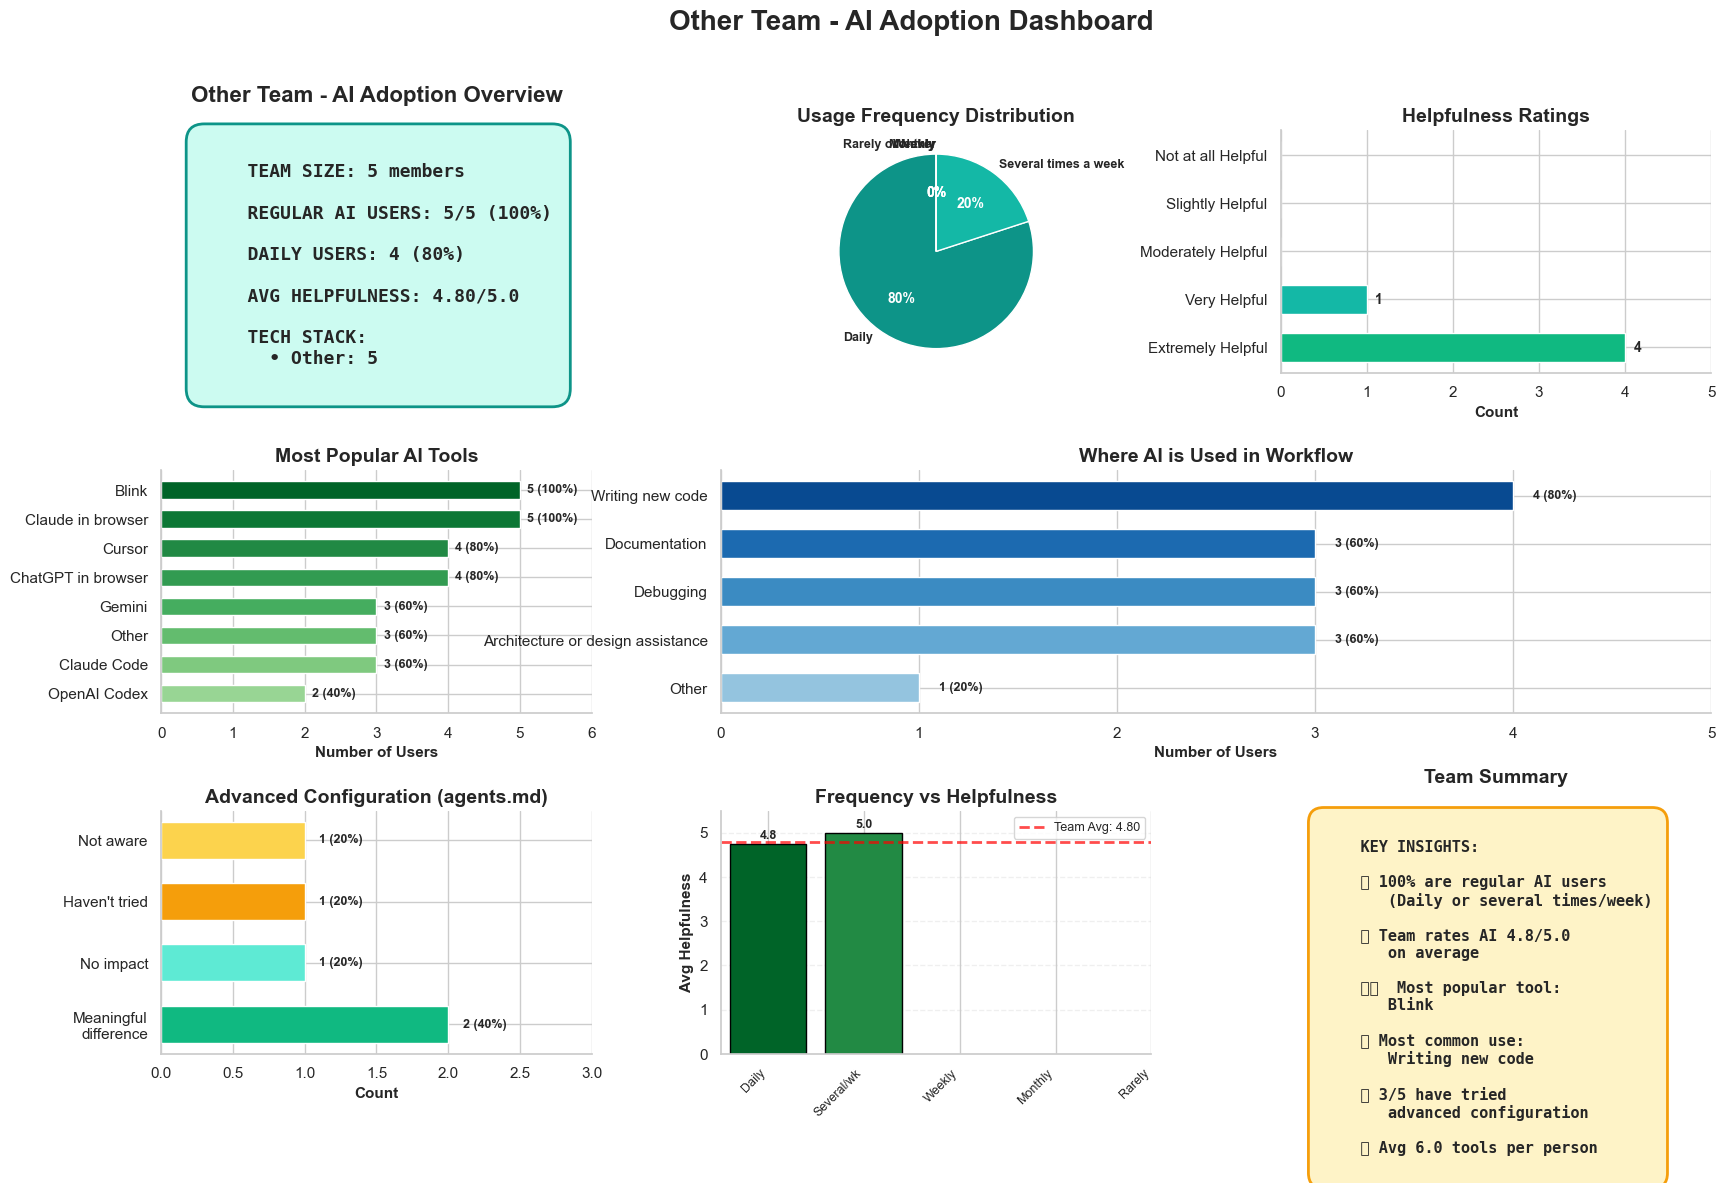


Other TEAM - AI ADOPTION REPORT

📊 Team Composition:
   Total members: 5
   Tech Stack breakdown:
      • Other: 5 (100%)

🎯 AI Adoption Metrics:
   Regular users (Daily/Several times week): 5/5 (100%)
   Daily users: 4 (80%)
   Average helpfulness rating: 4.80/5.0

🛠️  Top 3 Tools:
   1. Blink: 5 users (100%)
   2. Claude in browser: 5 users (100%)
   3. Cursor: 4 users (80%)

🔄 Top 3 Workflow Uses:
   1. Writing new code: 4 users (80%)
   2. Documentation: 3 users (60%)
   3. Debugging: 3 users (60%)

🚀 Advanced Configuration:
   Tried agents.md: 3/5 (60%)
   Found it helpful: 2/3




/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/3449138674.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andrew/Documents/Coder_Projects/AI_Usage/.venv/li

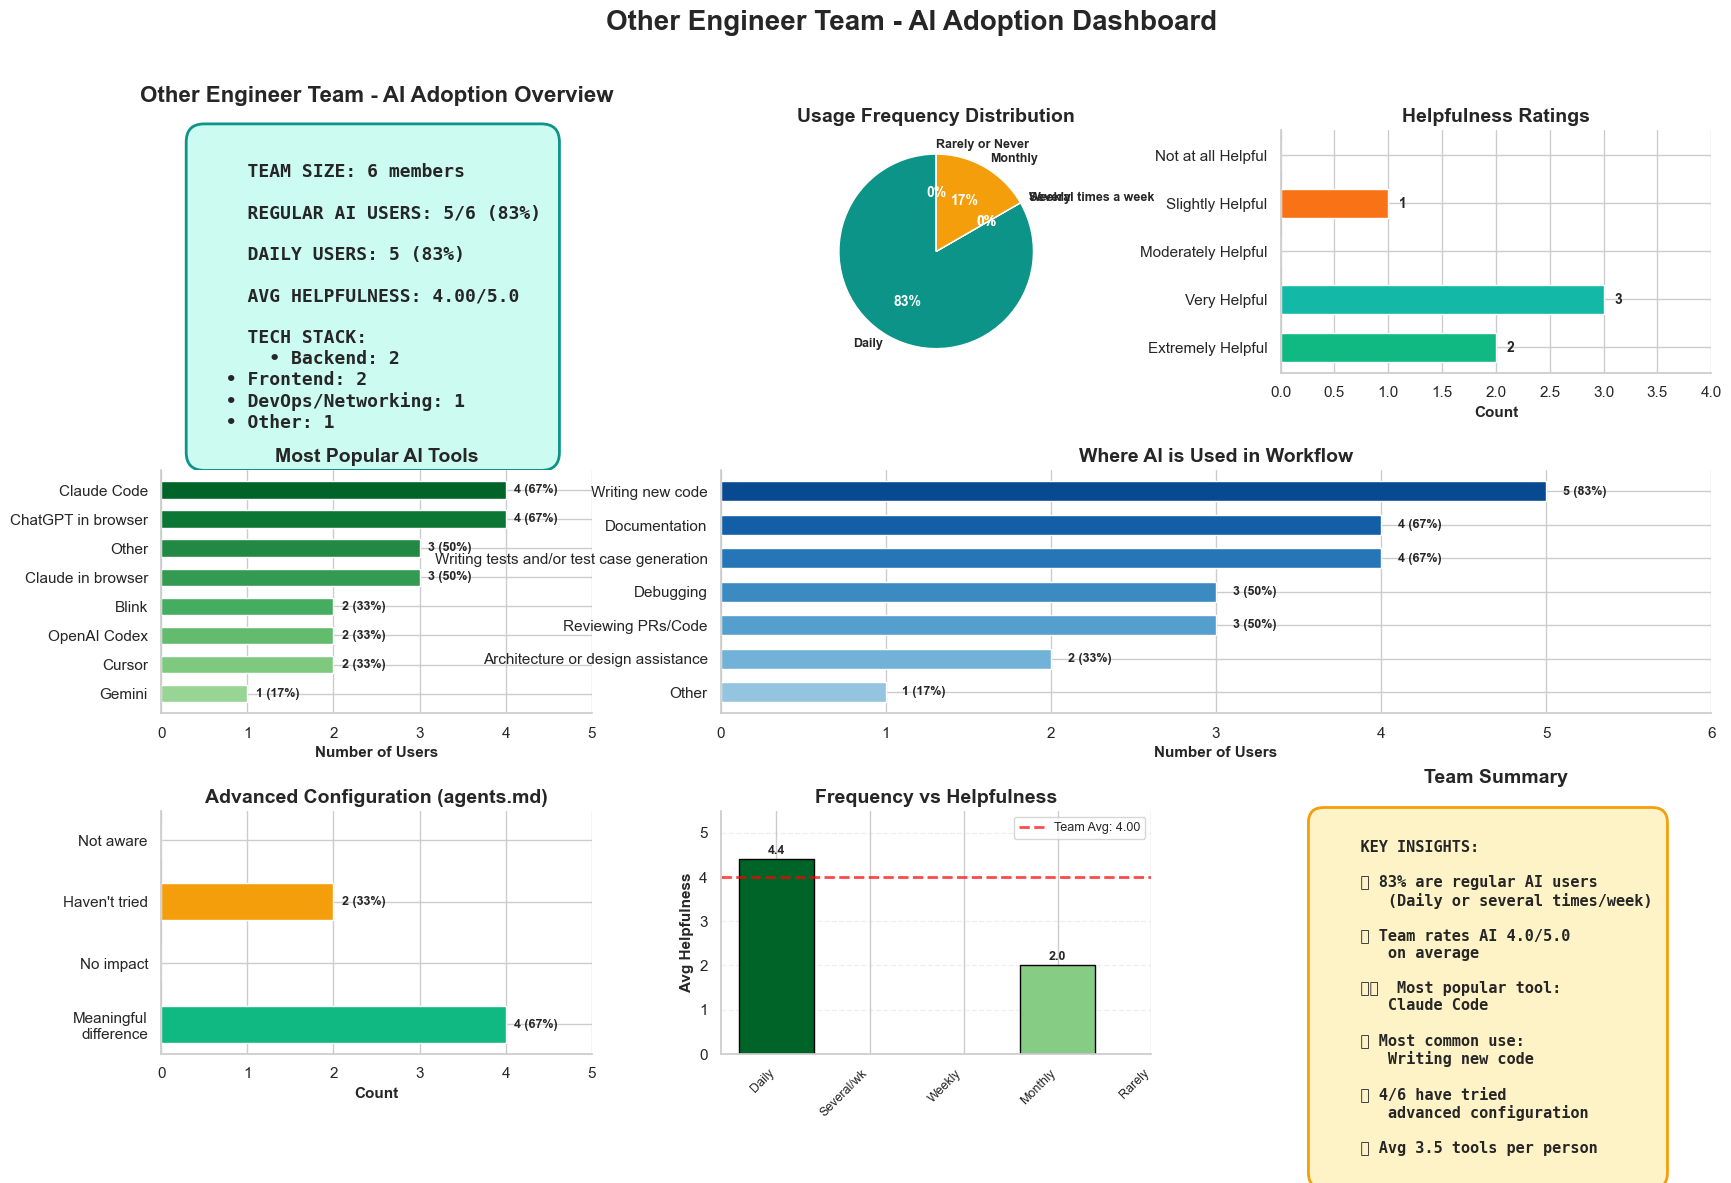


Other Engineer TEAM - AI ADOPTION REPORT

📊 Team Composition:
   Total members: 6
   Tech Stack breakdown:
      • Backend: 2 (33%)
      • Frontend: 2 (33%)
      • DevOps/Networking: 1 (17%)
      • Other: 1 (17%)

🎯 AI Adoption Metrics:
   Regular users (Daily/Several times week): 5/6 (83%)
   Daily users: 5 (83%)
   Average helpfulness rating: 4.00/5.0

🛠️  Top 3 Tools:
   1. Claude Code: 4 users (67%)
   2. ChatGPT in browser: 4 users (67%)
   3. Other: 3 users (50%)

🔄 Top 3 Workflow Uses:
   1. Writing new code: 5 users (83%)
   2. Documentation: 4 users (67%)
   3. Writing tests and/or test case generation: 4 users (67%)

🚀 Advanced Configuration:
   Tried agents.md: 4/6 (67%)
   Found it helpful: 4/4




In [ ]:

from collections import Counter

def create_team_dashboard(team_name, df):
    """
    Create a comprehensive AI adoption dashboard for a specific team.
    
    Parameters:
    -----------
    team_name : str
        Name of the team to create dashboard for
    df : pandas.DataFrame
        DataFrame containing survey responses
    """
    # Filter data for this team
    team_df = df[df['Which team are you a part of?'] == team_name].copy()
    
    if len(team_df) == 0:
        print(f"⚠️  No data found for team: {team_name}")
        return
    
    # Get column names (use dynamic lookup for helpfulness column)
    frequency_col = 'How frequently do you currently use AI tools/models in your development process?'
    
    # Find helpfulness column - handle quoted column names
    helpfulness_col = None
    
    # Try exact match first (with quotes)
    exact_name = '"On a scale of 1 to 5, how would you rate the overall helpfulness of AI in your daily development tasks?"'
    if exact_name in df.columns:
        helpfulness_col = exact_name
    else:
        # Try without quotes
        search_terms = [
            'how would you rate the overall helpfulness of AI',
            'rate the overall helpfulness',
            'helpfulness of AI'
        ]
        
        for term in search_terms:
            for col in df.columns:
                # Check both with and without quotes, case-insensitive
                col_lower = col.lower().replace('"', '').replace("'", '')
                if term.lower() in col_lower:
                    helpfulness_col = col
                    break
            if helpfulness_col:
                break
    
    if helpfulness_col is None:
        print(f"⚠️  Could not find helpfulness column for team: {team_name}")
        print(f"   Available columns with 'help' or 'rate':")
        for c in df.columns:
            if 'help' in c.lower() or 'rate' in c.lower():
                print(f"     - {c}")
        return
    tools_col = 'Which AI tools do you currently use for professional or personal development? (select all that apply)'
    workflow_col = 'Where do you primarily use AI in your development workflow? (Select all that apply)'
    agents_col = 'Have you ever written an `agents.md`, modified your `.claude` directory, or added context specifically for agents in other way?'
    tech_stack_col = 'Where do you primarily work in the tech stack'
    
    # ===== DATA PREPARATION =====
    # Create numeric mappings for analysis
    rating_values = {
        'Extremely Helpful': 5, 'Very Helpful': 4, 'Moderately Helpful': 3,
        'Slightly Helpful': 2, 'Not at all Helpful': 2, 'Not Helpful': 1
    }
    frequency_values = {
        'Daily': 5, 'Several times a week': 4, 'Weekly': 3,
        'Monthly': 2, 'Rarely or Never': 1
    }
    
    team_df['rating_numeric'] = team_df[helpfulness_col].map(rating_values)
    team_df['frequency_numeric'] = team_df[frequency_col].map(frequency_values)
    
    # ===== CALCULATE KEY METRICS =====
    team_size = len(team_df)
    avg_helpfulness = team_df['rating_numeric'].mean()
    daily_users = len(team_df[team_df[frequency_col] == 'Daily'])
    regular_users = len(team_df[team_df[frequency_col].isin(['Daily', 'Several times a week'])])
    regular_pct = (regular_users / team_size * 100)
    
    # ===== CREATE VISUALIZATION =====
    # Create figure with 3x3 grid layout
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
    
    # ===== SUBPLOT 1: Team Overview Stats (Top Left) =====
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.axis('off')
    
    overview_text = f"""
    TEAM SIZE: {team_size} members
    
    REGULAR AI USERS: {regular_users}/{team_size} ({regular_pct:.0f}%)
    
    DAILY USERS: {daily_users} ({daily_users/team_size*100:.0f}%)
    
    AVG HELPFULNESS: {avg_helpfulness:.2f}/5.0
    
    TECH STACK:
    """
    
    # Add tech stack breakdown
    tech_stack_counts = team_df[tech_stack_col].value_counts()
    for stack, count in tech_stack_counts.items():
        overview_text += f"  • {stack}: {count}\n"
    
    ax1.text(0.1, 0.95, overview_text, transform=ax1.transAxes,
             fontsize=13, weight='bold', va='top', family='monospace',
             bbox=dict(boxstyle='round,pad=1', facecolor='#CCFBF1', edgecolor='#0D9488', linewidth=2))
    ax1.set_title(f'{team_name} Team - AI Adoption Overview', fontsize=16, weight='bold', pad=20)
    
    # ===== SUBPLOT 2: Frequency Distribution (Top Middle) =====
    ax2 = fig.add_subplot(gs[0, 1])
    
    frequency_order = ['Daily', 'Several times a week', 'Weekly', 'Monthly', 'Rarely or Never']
    frequency_counts = team_df[frequency_col].value_counts().reindex(frequency_order, fill_value=0)
    
    colors_freq = ['#0D9488', '#14B8A6', '#5EEAD4', '#F59E0B', '#FCD34D']
    wedges, texts, autotexts = ax2.pie(
        frequency_counts.values,
        labels=frequency_counts.index,
        autopct='%1.0f%%',
        startangle=90,
        colors=colors_freq,
        textprops={'fontsize': 9, 'weight': 'bold'}
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)
    
    ax2.set_title('Usage Frequency Distribution', fontsize=14, weight='bold')
    
    # ===== SUBPLOT 3: Helpfulness Ratings (Top Right) =====
    ax3 = fig.add_subplot(gs[0, 2])
    
    rating_order = ['Extremely Helpful', 'Very Helpful', 'Moderately Helpful', 'Slightly Helpful', 'Not at all Helpful']
    rating_counts = team_df[helpfulness_col].value_counts().reindex(rating_order, fill_value=0)
    
    colors_rating = ['#10B981', '#14B8A6', '#F59E0B', '#F97316', '#EF4444']
    bars = ax3.barh(rating_order, rating_counts.values, color=colors_rating, height=0.6)
    
    for bar, count in zip(bars, rating_counts.values):
        if count > 0:
            ax3.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                    f'{int(count)}', va='center', fontsize=10, weight='bold')
    
    ax3.set_xlabel('Count', fontsize=11, weight='bold')
    ax3.set_title('Helpfulness Ratings', fontsize=14, weight='bold')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xlim(0, max(rating_counts.values) + 1)
    
    # ===== SUBPLOT 4: Top Tools Used (Middle Left) =====
    ax4 = fig.add_subplot(gs[1, 0])
    
    all_tools = []
    for response in team_df[tools_col].dropna():
        tools = [tool.strip() for tool in response.split(',')]
        all_tools.extend(tools)
    
    tool_counts = Counter(all_tools)
    tools_df = pd.DataFrame(tool_counts.items(), columns=['Tool', 'Count'])
    tools_df = tools_df.sort_values('Count', ascending=True).tail(8)  # Top 8 tools
    
    colors_tools = plt.cm.Greens(np.linspace(0.4, 0.9, len(tools_df)))
    bars = ax4.barh(tools_df['Tool'], tools_df['Count'], color=colors_tools, height=0.6)
    
    for bar, count in zip(bars, tools_df['Count']):
        pct = (count / team_size * 100)
        ax4.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                f'{int(count)} ({pct:.0f}%)', va='center', fontsize=9, weight='bold')
    
    ax4.set_xlabel('Number of Users', fontsize=11, weight='bold')
    ax4.set_title('Most Popular AI Tools', fontsize=14, weight='bold')
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.set_xlim(0, max(tools_df['Count']) + 1)
    
    # ===== SUBPLOT 5: Workflow Usage (Middle Middle & Right - spanning 2 columns) =====
    ax5 = fig.add_subplot(gs[1, 1:])
    
    all_workflows = []
    for response in team_df[workflow_col].dropna():
        workflows = [wf.strip() for wf in response.split(',')]
        all_workflows.extend(workflows)
    
    workflow_counts = Counter(all_workflows)
    workflow_df = pd.DataFrame(workflow_counts.items(), columns=['Workflow', 'Count'])
    workflow_df = workflow_df.sort_values('Count', ascending=True)
    
    colors_workflow = plt.cm.Blues(np.linspace(0.4, 0.9, len(workflow_df)))
    bars = ax5.barh(workflow_df['Workflow'], workflow_df['Count'], color=colors_workflow, height=0.6)
    
    for bar, count in zip(bars, workflow_df['Count']):
        pct = (count / team_size * 100)
        ax5.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                f'{int(count)} ({pct:.0f}%)', va='center', fontsize=9, weight='bold')
    
    ax5.set_xlabel('Number of Users', fontsize=11, weight='bold')
    ax5.set_title('Where AI is Used in Workflow', fontsize=14, weight='bold')
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)
    ax5.set_xlim(0, max(workflow_df['Count']) + 1)
    
    # ===== SUBPLOT 6: Advanced Configuration (agents.md) (Bottom Left) =====
    ax6 = fig.add_subplot(gs[2, 0])
    
    agents_order = [
        'Yes -- and it made a meaningful difference',
        'Yes -- but I didn\'t notice much impact',
        'No -- I know it\'s possible but haven\'t taken the time',
        'No -- I wasn\'t aware that was possible'
    ]
    agents_counts = team_df[agents_col].value_counts().reindex(agents_order, fill_value=0)
    
    colors_agents = ['#10B981', '#5EEAD4', '#F59E0B', '#FCD34D']
    
    # Wrap labels
    wrapped_labels = [
        'Meaningful\ndifference',
        'No impact',
        'Haven\'t tried',
        'Not aware'
    ]
    
    bars = ax6.barh(wrapped_labels, agents_counts.values, color=colors_agents, height=0.6)
    
    for bar, count in zip(bars, agents_counts.values):
        if count > 0:
            pct = (count / team_size * 100)
            ax6.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                    f'{int(count)} ({pct:.0f}%)', va='center', fontsize=9, weight='bold')
    
    ax6.set_xlabel('Count', fontsize=11, weight='bold')
    ax6.set_title('Advanced Configuration (agents.md)', fontsize=14, weight='bold')
    ax6.spines['top'].set_visible(False)
    ax6.spines['right'].set_visible(False)
    ax6.set_xlim(0, max(agents_counts.values) + 1)
    
    # ===== SUBPLOT 7: Frequency vs Helpfulness for this team (Bottom Middle) =====
    ax7 = fig.add_subplot(gs[2, 1])
    
    freq_help = team_df.groupby(frequency_col)['rating_numeric'].mean().reindex(frequency_order)
    
    x_pos = np.arange(len(frequency_order))
    colors_bar = plt.cm.Greens(np.linspace(0.9, 0.3, len(frequency_order)))
    bars = ax7.bar(x_pos, freq_help.values, color=colors_bar, edgecolor='black', linewidth=1)
    
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax7.text(bar.get_x() + bar.get_width()/2, height + 0.05,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9, weight='bold')
    
    ax7.axhline(avg_helpfulness, color='red', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Team Avg: {avg_helpfulness:.2f}')
    
    ax7.set_xticks(x_pos)
    ax7.set_xticklabels(['Daily', 'Several/wk', 'Weekly', 'Monthly', 'Rarely'], 
                         rotation=45, ha='right', fontsize=9)
    ax7.set_ylabel('Avg Helpfulness', fontsize=11, weight='bold')
    ax7.set_title('Frequency vs Helpfulness', fontsize=14, weight='bold')
    ax7.set_ylim(0, 5.5)
    ax7.spines['top'].set_visible(False)
    ax7.spines['right'].set_visible(False)
    ax7.legend(fontsize=9)
    ax7.grid(axis='y', alpha=0.3, linestyle='--')
    
    # ===== SUBPLOT 8: Key Insights (Bottom Right) =====
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    
    # Calculate insights
    top_tool = tools_df.iloc[-1]['Tool'] if len(tools_df) > 0 else 'N/A'
    top_workflow = workflow_df.iloc[-1]['Workflow'] if len(workflow_df) > 0 else 'N/A'
    tried_agents = agents_counts.iloc[0] + agents_counts.iloc[1]
    
    insights_text = f"""
    KEY INSIGHTS:
    
    📊 {regular_pct:.0f}% are regular AI users
       (Daily or several times/week)
    
    ⭐ Team rates AI {avg_helpfulness:.1f}/5.0
       on average
    
    🛠️  Most popular tool:
       {top_tool}
    
    🔄 Most common use:
       {top_workflow}
    
    🚀 {tried_agents}/{team_size} have tried
       advanced configuration
    
    💡 Avg {len(all_tools)/team_size:.1f} tools per person
    """
    
    ax8.text(0.1, 0.95, insights_text, transform=ax8.transAxes,
             fontsize=11, weight='bold', va='top', family='monospace',
             bbox=dict(boxstyle='round,pad=1', facecolor='#FEF3C7', edgecolor='#F59E0B', linewidth=2))
    ax8.set_title('Team Summary', fontsize=14, weight='bold', pad=20)
    
    # Overall title
    fig.suptitle(f'{team_name} Team - AI Adoption Dashboard', 
                 fontsize=20, weight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Print text summary
    print(f"\n{'='*80}")
    print(f"{team_name} TEAM - AI ADOPTION REPORT")
    print(f"{'='*80}")
    print(f"\n📊 Team Composition:")
    print(f"   Total members: {team_size}")
    print(f"   Tech Stack breakdown:")
    for stack, count in tech_stack_counts.items():
        print(f"      • {stack}: {count} ({count/team_size*100:.0f}%)")
    
    print(f"\n🎯 AI Adoption Metrics:")
    print(f"   Regular users (Daily/Several times week): {regular_users}/{team_size} ({regular_pct:.0f}%)")
    print(f"   Daily users: {daily_users} ({daily_users/team_size*100:.0f}%)")
    print(f"   Average helpfulness rating: {avg_helpfulness:.2f}/5.0")
    
    print(f"\n🛠️  Top 3 Tools:")
    for i, (idx, row) in enumerate(tools_df.tail(3).iloc[::-1].iterrows(), 1):
        print(f"   {i}. {row['Tool']}: {int(row['Count'])} users ({row['Count']/team_size*100:.0f}%)")
    
    print(f"\n🔄 Top 3 Workflow Uses:")
    for i, (idx, row) in enumerate(workflow_df.tail(3).iloc[::-1].iterrows(), 1):
        print(f"   {i}. {row['Workflow']}: {int(row['Count'])} users ({row['Count']/team_size*100:.0f}%)")
    
    print(f"\n🚀 Advanced Configuration:")
    print(f"   Tried agents.md: {tried_agents}/{team_size} ({tried_agents/team_size*100:.0f}%)")
    print(f"   Found it helpful: {agents_counts.iloc[0]}/{tried_agents if tried_agents > 0 else 1}")
    
    print(f"\n{'='*80}\n")


# Generate dashboards for all engineering teams
teams = ['Kiwi', 'Coconut', 'Mango', 'Pineapple', 'Other', 'Other Engineer']

for team in teams:
    create_team_dashboard(team, df_raw)